# 20. 난 스케치를 할 테니 너는 채색을 하거라

## 13. 프로젝트 : Segmentation map으로 도로 이미지 만들기
이전 Pix2Pix 논문에서 제시한 결과 중에 아래와 같은 실험 결과가 있었습니다. 도로의 레이블 정보를 활용해 이미지를 생성해낸 결과입니다.

<img src="./image/p2p_result.png" />

이번 프로젝트는 위와 같은 데이터셋을 이용해 Pix2Pix를 학습시켜보는 것입니다. 데이터셋은 아래에서 다운로드할 수 있다.<br>
1000개의 학습용 이미지 및 5개의 평가 이미지를 포함한다.

이전 포켓몬 데이터에서 사용했던 스케치와는 조금 다른 레이블 정보 이미지를 입력으로 사용하기 때문에, 전처리 과정에 대해 약간의 혼란이 있을 수 있지만 크게 다른 과정은 없다.<br>
아래 Tensroflow에서 제공하는 Pix2Pix 튜토리얼은 위 이미지와 비슷한 레이블 정보 이미지를 사용하기 때문에 좋은 참고 자료가 될 수 있을 것 같다.

프로젝트 시작에 어려움이 있다면 아래 튜토리얼을 참고하시면서 이번 프로젝트를 수행해보자.<br>
(아래 튜토리얼은 Pix2Pix 구조를 Functional API를 이용해 구현하기 때문에 이번에 진행한 Subclassing 방법을 이용한 모델 구현과 비교하면서 구현 방법에 대해서도 공부해보자)

* [Tensorflow Pix2Pix Tutorial](https://www.tensorflow.org/tutorials/generative/pix2pix?hl=ko)

### 프로젝트 수행
---
프로젝트를 진행하면서 필수로 수행해야 할 사항은 다음과 같다.

1. 데이터에 한 가지 이상의 __augmentation 방법을 적용__하여 학습하자.<br>
(어떠한 방법을 사용했는지 적자.)
2. 이전에 구현했던 두 개의 Generator 중 Encoder와 Decoder간에 skip connection이 있는 __U-Net Generator를 사용__해보자.
3. 모델 학습 후, 학습된 Generator를 이용해 테스트한다. 테스트 데이터는 다운받았던 "val" 폴더 내 이미지를 사용하자.
4. 1개 이상의 이미지에 대해 테스트 과정을 거친 후 그 결과를 __스케치, 생성된 사진, 실제 사진 순서로 나란히 시각화__하자.
5. 모델을 충분히 학습하기에 시간이 부족할 수 있다. 적어도 10 epoch 이상 학습하며 __중간 손실 값에 대한 로그__를 남기자. 좋은 결과를 얻기 위해선 긴 학습 시간이 필요하므로 테스트 결과는 만족스럽지 않아도 괜찮다.

In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
import os

data_path = os.getenv('HOME')+'/AIFFEL/Exploration/E20_Pix2Pix/data/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


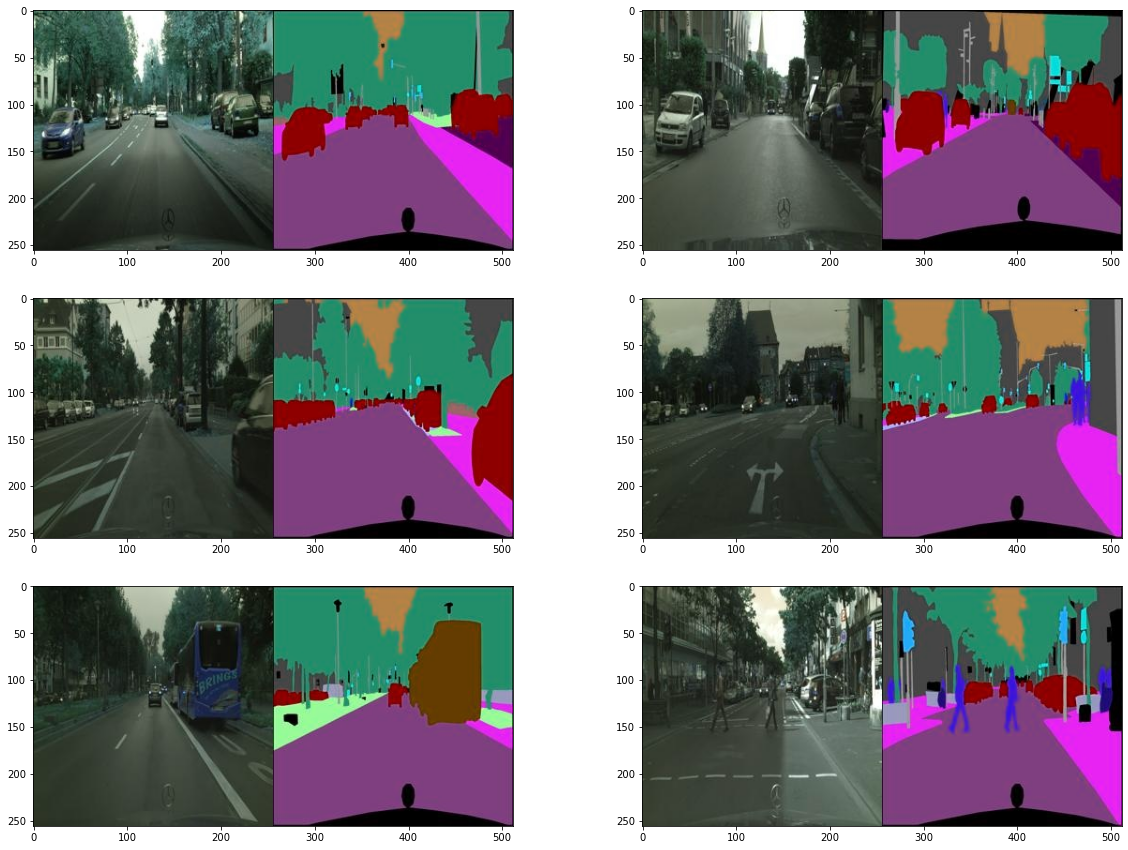

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [4]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


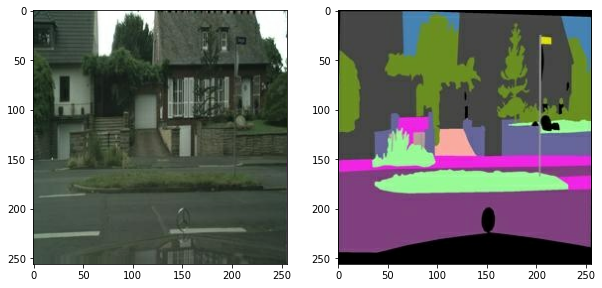

In [5]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, w:, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, :w, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
colored, sketch = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

#### augmentation 방법

In [6]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

`apply_augmentation` 함수는 스케치 및 채색된 2개 이미지를 입력으로 받아 여러 가지 연산을 두 이미지에 동일하게 적용한다.

__apply_augmentation 함수에 두 이미지가 입력되면 거치는 과정__

1. 두 이미지가 채널 축으로 연결된다. (tf.concat). 두 이미지가 각각 3채널인 경우 6채널이 된다.
2. 1.의 결과에 각 50% 확률로 Refection padding 또는 constant padding이 30픽셀의 pad width 만큼 적용된다. (tf.pad)
3. 2.의 결과에서 (256,256,6) 크기를 가진 이미지를 임의로 잘라낸다. (tf.image.random_crop) 
4. 3.의 결과를 50% 확률로 가로로 뒤집는다. (tf.image.random_flip_left_right)
5. 4.의 결과를 50% 확률로 세로로 뒤집는다. (tf.image.random_flip_up_down) 
6. 5.의 결과를 50% 확률로 회전시킨다. (tf.image.rot90)

위와 같이 구성한 함수를 데이터에 적용해 시각화 해보자.

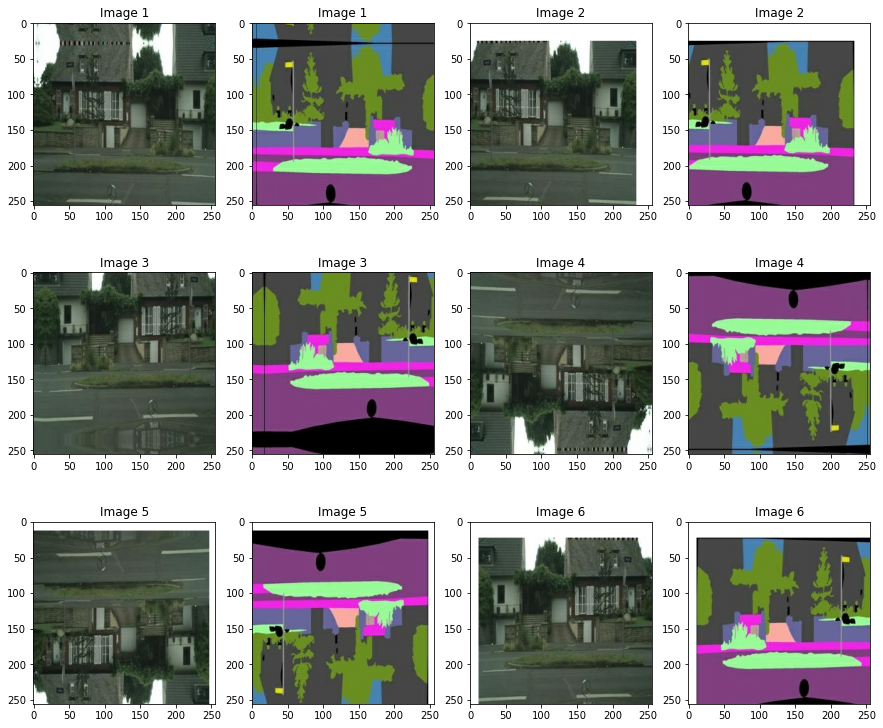

In [7]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

매우 다양한 이미지가 생성된다. 여기서 사용한 augmentation 방법 외에 더 많은 방법을 활용한다면 더욱더 다양한 데이터셋을 만들어 좋은 일반화 결과를 기대해 볼 수 있다.

마지막으로 위 과정들을 학습 데이터에 적용하며, 잘 적용되었는지 하나의 이미지만 시각화하여 확인해 보겠다.

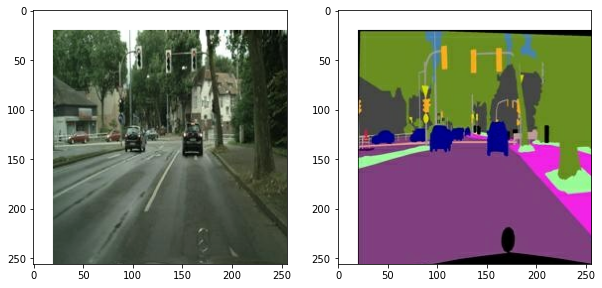

In [8]:
from tensorflow import data

def get_train(img_path):
    colored, sketch  = load_img(img_path)
    colored, sketch  = apply_augmentation(sketch, colored)
    return colored, sketch 

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

#### Generator 구현하기

In [9]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

In [10]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [11]:
Encoder().get_summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block (EncodeBlock)   (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_1 (EncodeBlock) (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_2 (EncodeBlock) (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_3 (EncodeBlock) (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_4 (EncodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_5 (EncodeBlock) (None, 4, 4, 512)         419635

In [12]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,256)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [13]:
Decoder().get_summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 1, 256)]       0         
_________________________________________________________________
decode_block (DecodeBlock)   (None, 2, 2, 512)         2099200   
_________________________________________________________________
decode_block_1 (DecodeBlock) (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_2 (DecodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_3 (DecodeBlock) (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_4 (DecodeBlock) (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_5 (DecodeBlock) (None, 64, 64, 128)       5248

In [14]:
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
   
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        

EncoderDecoderGenerator().get_summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encoder_1 (Encoder)          (None, 1, 1, 512)         19544576  
_________________________________________________________________
decoder_1 (Decoder)          (None, 256, 256, 3)       19542784  
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


Generator를 잘 작동시키기 위해서는 약 4000만 개의 파라미터를 잘 학습시켜야 한다.

In [15]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

In [16]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

이제야 Generator 구현이 끝났다.

마지막으로 완성된 U-Net 구조 Generator 내부의 각 출력이 적절한지 아래 코드로 확인해보자.

In [17]:
UNetGenerator().get_summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_16 (EncodeBlock)   (None, 128, 128, 64) 3072        input_4[0][0]                    
__________________________________________________________________________________________________
encode_block_17 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_16[0][0]            
__________________________________________________________________________________________________
encode_block_18 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_17[0][0]            
____________________________________________________________________________________________

#### Discriminator 구현하기

In [18]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [19]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_45 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


In [20]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [21]:
Discriminator().get_summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_6[0][0]                    
                                                                 input_7[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

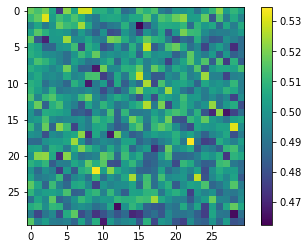

In [22]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

In [23]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

In [24]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [25]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [26]:
EPOCHS = 300

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.9500                     
L1_loss:0.3664                     
Discriminator_loss:1.2351

EPOCH[1] - STEP[20]                     
Generator_loss:0.9875                     
L1_loss:0.3457                     
Discriminator_loss:1.1578

EPOCH[1] - STEP[30]                     
Generator_loss:1.3613                     
L1_loss:0.2742                     
Discriminator_loss:1.0049

EPOCH[1] - STEP[40]                     
Generator_loss:1.3412                     
L1_loss:0.3069                     
Discriminator_loss:0.7542

EPOCH[1] - STEP[50]                     
Generator_loss:1.7915                     
L1_loss:0.2328                     
Discriminator_loss:0.8515

EPOCH[1] - STEP[60]                     
Generator_loss:1.8194                     
L1_loss:0.2158                     
Discriminator_loss:0.4441

EPOCH[1] - STEP[70]                     
Generator_loss:1.4222                     
L1_loss:0.2849                    

EPOCH[3] - STEP[70]                     
Generator_loss:1.8733                     
L1_loss:0.2319                     
Discriminator_loss:0.9442

EPOCH[3] - STEP[80]                     
Generator_loss:0.9551                     
L1_loss:0.2244                     
Discriminator_loss:0.7192

EPOCH[3] - STEP[90]                     
Generator_loss:1.6972                     
L1_loss:0.1909                     
Discriminator_loss:1.1668

EPOCH[3] - STEP[100]                     
Generator_loss:1.1535                     
L1_loss:0.2424                     
Discriminator_loss:0.7316

EPOCH[3] - STEP[110]                     
Generator_loss:1.6798                     
L1_loss:0.2054                     
Discriminator_loss:0.7533

EPOCH[3] - STEP[120]                     
Generator_loss:1.9358                     
L1_loss:0.1819                     
Discriminator_loss:0.5595

EPOCH[3] - STEP[130]                     
Generator_loss:2.0366                     
L1_loss:0.1884                

EPOCH[5] - STEP[130]                     
Generator_loss:1.8457                     
L1_loss:0.2022                     
Discriminator_loss:0.4651

EPOCH[5] - STEP[140]                     
Generator_loss:0.8284                     
L1_loss:0.1798                     
Discriminator_loss:0.8541

EPOCH[5] - STEP[150]                     
Generator_loss:0.6572                     
L1_loss:0.1938                     
Discriminator_loss:1.0911

EPOCH[5] - STEP[160]                     
Generator_loss:1.5066                     
L1_loss:0.2267                     
Discriminator_loss:0.3600

EPOCH[5] - STEP[170]                     
Generator_loss:0.6222                     
L1_loss:0.1764                     
Discriminator_loss:1.2174

EPOCH[5] - STEP[180]                     
Generator_loss:1.0264                     
L1_loss:0.1700                     
Discriminator_loss:0.8190

EPOCH[5] - STEP[190]                     
Generator_loss:2.5038                     
L1_loss:0.2056             

EPOCH[7] - STEP[190]                     
Generator_loss:2.6259                     
L1_loss:0.2700                     
Discriminator_loss:0.1906

EPOCH[7] - STEP[200]                     
Generator_loss:1.3634                     
L1_loss:0.1666                     
Discriminator_loss:0.6216

EPOCH[7] - STEP[210]                     
Generator_loss:0.7456                     
L1_loss:0.1823                     
Discriminator_loss:0.8362

EPOCH[7] - STEP[220]                     
Generator_loss:2.8068                     
L1_loss:0.1420                     
Discriminator_loss:0.8218

EPOCH[7] - STEP[230]                     
Generator_loss:1.6004                     
L1_loss:0.2266                     
Discriminator_loss:0.3934

EPOCH[7] - STEP[240]                     
Generator_loss:2.0940                     
L1_loss:0.1395                     
Discriminator_loss:0.5641

EPOCH[7] - STEP[250]                     
Generator_loss:1.3155                     
L1_loss:0.2109             

EPOCH[9] - STEP[250]                     
Generator_loss:4.0637                     
L1_loss:0.1517                     
Discriminator_loss:2.5384

EPOCH[10] - STEP[10]                     
Generator_loss:0.8499                     
L1_loss:0.1530                     
Discriminator_loss:1.2064

EPOCH[10] - STEP[20]                     
Generator_loss:2.5945                     
L1_loss:0.1547                     
Discriminator_loss:1.0739

EPOCH[10] - STEP[30]                     
Generator_loss:1.0405                     
L1_loss:0.1701                     
Discriminator_loss:0.7561

EPOCH[10] - STEP[40]                     
Generator_loss:2.3591                     
L1_loss:0.2105                     
Discriminator_loss:0.4950

EPOCH[10] - STEP[50]                     
Generator_loss:1.7594                     
L1_loss:0.1998                     
Discriminator_loss:0.3878

EPOCH[10] - STEP[60]                     
Generator_loss:1.4757                     
L1_loss:0.1827             

EPOCH[12] - STEP[60]                     
Generator_loss:1.4155                     
L1_loss:0.1937                     
Discriminator_loss:0.4548

EPOCH[12] - STEP[70]                     
Generator_loss:2.1683                     
L1_loss:0.1545                     
Discriminator_loss:1.8458

EPOCH[12] - STEP[80]                     
Generator_loss:1.9558                     
L1_loss:0.1515                     
Discriminator_loss:1.0504

EPOCH[12] - STEP[90]                     
Generator_loss:2.1442                     
L1_loss:0.2026                     
Discriminator_loss:0.4322

EPOCH[12] - STEP[100]                     
Generator_loss:0.7078                     
L1_loss:0.1679                     
Discriminator_loss:0.8078

EPOCH[12] - STEP[110]                     
Generator_loss:2.7148                     
L1_loss:0.2155                     
Discriminator_loss:0.4097

EPOCH[12] - STEP[120]                     
Generator_loss:2.5153                     
L1_loss:0.1730          

EPOCH[14] - STEP[120]                     
Generator_loss:1.0377                     
L1_loss:0.1671                     
Discriminator_loss:0.7833

EPOCH[14] - STEP[130]                     
Generator_loss:1.4432                     
L1_loss:0.1807                     
Discriminator_loss:0.3995

EPOCH[14] - STEP[140]                     
Generator_loss:2.5985                     
L1_loss:0.1495                     
Discriminator_loss:1.6214

EPOCH[14] - STEP[150]                     
Generator_loss:0.8142                     
L1_loss:0.1730                     
Discriminator_loss:0.7716

EPOCH[14] - STEP[160]                     
Generator_loss:2.0720                     
L1_loss:0.1857                     
Discriminator_loss:0.4578

EPOCH[14] - STEP[170]                     
Generator_loss:2.9178                     
L1_loss:0.1869                     
Discriminator_loss:0.7902

EPOCH[14] - STEP[180]                     
Generator_loss:1.4801                     
L1_loss:0.1680      

EPOCH[16] - STEP[180]                     
Generator_loss:1.5670                     
L1_loss:0.1656                     
Discriminator_loss:0.6157

EPOCH[16] - STEP[190]                     
Generator_loss:0.8725                     
L1_loss:0.1536                     
Discriminator_loss:0.6572

EPOCH[16] - STEP[200]                     
Generator_loss:1.6441                     
L1_loss:0.1587                     
Discriminator_loss:0.6666

EPOCH[16] - STEP[210]                     
Generator_loss:2.0243                     
L1_loss:0.1196                     
Discriminator_loss:1.1608

EPOCH[16] - STEP[220]                     
Generator_loss:1.8195                     
L1_loss:0.1930                     
Discriminator_loss:0.4079

EPOCH[16] - STEP[230]                     
Generator_loss:2.3128                     
L1_loss:0.1941                     
Discriminator_loss:0.2141

EPOCH[16] - STEP[240]                     
Generator_loss:1.6706                     
L1_loss:0.1717      

EPOCH[18] - STEP[240]                     
Generator_loss:1.9061                     
L1_loss:0.1508                     
Discriminator_loss:0.8628

EPOCH[18] - STEP[250]                     
Generator_loss:1.9465                     
L1_loss:0.1659                     
Discriminator_loss:0.6955

EPOCH[19] - STEP[10]                     
Generator_loss:2.1958                     
L1_loss:0.1699                     
Discriminator_loss:0.4515

EPOCH[19] - STEP[20]                     
Generator_loss:2.7414                     
L1_loss:0.1940                     
Discriminator_loss:1.4042

EPOCH[19] - STEP[30]                     
Generator_loss:1.8926                     
L1_loss:0.1486                     
Discriminator_loss:0.5127

EPOCH[19] - STEP[40]                     
Generator_loss:0.8732                     
L1_loss:0.1445                     
Discriminator_loss:1.0568

EPOCH[19] - STEP[50]                     
Generator_loss:1.9197                     
L1_loss:0.1742           

EPOCH[21] - STEP[50]                     
Generator_loss:4.2726                     
L1_loss:0.1283                     
Discriminator_loss:0.7360

EPOCH[21] - STEP[60]                     
Generator_loss:2.5030                     
L1_loss:0.1716                     
Discriminator_loss:0.3011

EPOCH[21] - STEP[70]                     
Generator_loss:1.3195                     
L1_loss:0.1567                     
Discriminator_loss:1.2010

EPOCH[21] - STEP[80]                     
Generator_loss:2.3748                     
L1_loss:0.1985                     
Discriminator_loss:0.1920

EPOCH[21] - STEP[90]                     
Generator_loss:1.9160                     
L1_loss:0.1601                     
Discriminator_loss:0.4121

EPOCH[21] - STEP[100]                     
Generator_loss:1.9928                     
L1_loss:0.1675                     
Discriminator_loss:0.3764

EPOCH[21] - STEP[110]                     
Generator_loss:3.0806                     
L1_loss:0.1973           

EPOCH[23] - STEP[110]                     
Generator_loss:3.2838                     
L1_loss:0.1914                     
Discriminator_loss:0.5919

EPOCH[23] - STEP[120]                     
Generator_loss:0.8823                     
L1_loss:0.2106                     
Discriminator_loss:0.7133

EPOCH[23] - STEP[130]                     
Generator_loss:2.3600                     
L1_loss:0.1585                     
Discriminator_loss:0.5392

EPOCH[23] - STEP[140]                     
Generator_loss:2.3563                     
L1_loss:0.2065                     
Discriminator_loss:0.1934

EPOCH[23] - STEP[150]                     
Generator_loss:1.8051                     
L1_loss:0.1545                     
Discriminator_loss:0.3488

EPOCH[23] - STEP[160]                     
Generator_loss:1.3820                     
L1_loss:0.1841                     
Discriminator_loss:0.6141

EPOCH[23] - STEP[170]                     
Generator_loss:3.1947                     
L1_loss:0.1516      

EPOCH[25] - STEP[170]                     
Generator_loss:2.6335                     
L1_loss:0.1425                     
Discriminator_loss:0.5213

EPOCH[25] - STEP[180]                     
Generator_loss:2.0110                     
L1_loss:0.1220                     
Discriminator_loss:0.5457

EPOCH[25] - STEP[190]                     
Generator_loss:2.9859                     
L1_loss:0.1312                     
Discriminator_loss:1.2153

EPOCH[25] - STEP[200]                     
Generator_loss:1.9283                     
L1_loss:0.2048                     
Discriminator_loss:0.3462

EPOCH[25] - STEP[210]                     
Generator_loss:2.5828                     
L1_loss:0.1667                     
Discriminator_loss:0.1742

EPOCH[25] - STEP[220]                     
Generator_loss:3.5957                     
L1_loss:0.1223                     
Discriminator_loss:1.4690

EPOCH[25] - STEP[230]                     
Generator_loss:3.4684                     
L1_loss:0.1736      

EPOCH[27] - STEP[230]                     
Generator_loss:2.0086                     
L1_loss:0.1444                     
Discriminator_loss:0.4362

EPOCH[27] - STEP[240]                     
Generator_loss:1.4165                     
L1_loss:0.1901                     
Discriminator_loss:0.5583

EPOCH[27] - STEP[250]                     
Generator_loss:1.8130                     
L1_loss:0.1507                     
Discriminator_loss:0.3461

EPOCH[28] - STEP[10]                     
Generator_loss:3.3237                     
L1_loss:0.1295                     
Discriminator_loss:0.8583

EPOCH[28] - STEP[20]                     
Generator_loss:2.8700                     
L1_loss:0.1766                     
Discriminator_loss:0.3303

EPOCH[28] - STEP[30]                     
Generator_loss:2.3598                     
L1_loss:0.1621                     
Discriminator_loss:0.2715

EPOCH[28] - STEP[40]                     
Generator_loss:1.9615                     
L1_loss:0.1933          

EPOCH[30] - STEP[40]                     
Generator_loss:0.7439                     
L1_loss:0.2111                     
Discriminator_loss:1.1602

EPOCH[30] - STEP[50]                     
Generator_loss:2.7520                     
L1_loss:0.1310                     
Discriminator_loss:0.3739

EPOCH[30] - STEP[60]                     
Generator_loss:2.9685                     
L1_loss:0.1565                     
Discriminator_loss:1.2322

EPOCH[30] - STEP[70]                     
Generator_loss:0.9132                     
L1_loss:0.1453                     
Discriminator_loss:0.8406

EPOCH[30] - STEP[80]                     
Generator_loss:1.7188                     
L1_loss:0.1746                     
Discriminator_loss:0.3176

EPOCH[30] - STEP[90]                     
Generator_loss:1.5891                     
L1_loss:0.1863                     
Discriminator_loss:0.3304

EPOCH[30] - STEP[100]                     
Generator_loss:4.1301                     
L1_loss:0.1867            

EPOCH[32] - STEP[100]                     
Generator_loss:2.5443                     
L1_loss:0.1516                     
Discriminator_loss:0.3242

EPOCH[32] - STEP[110]                     
Generator_loss:1.3934                     
L1_loss:0.1598                     
Discriminator_loss:0.5536

EPOCH[32] - STEP[120]                     
Generator_loss:0.9884                     
L1_loss:0.1948                     
Discriminator_loss:0.7307

EPOCH[32] - STEP[130]                     
Generator_loss:1.8011                     
L1_loss:0.1263                     
Discriminator_loss:0.3849

EPOCH[32] - STEP[140]                     
Generator_loss:3.9994                     
L1_loss:0.1817                     
Discriminator_loss:1.2484

EPOCH[32] - STEP[150]                     
Generator_loss:2.2019                     
L1_loss:0.1840                     
Discriminator_loss:0.2213

EPOCH[32] - STEP[160]                     
Generator_loss:2.0279                     
L1_loss:0.1596      

EPOCH[34] - STEP[160]                     
Generator_loss:0.5388                     
L1_loss:0.1495                     
Discriminator_loss:1.2441

EPOCH[34] - STEP[170]                     
Generator_loss:2.6288                     
L1_loss:0.1473                     
Discriminator_loss:0.2115

EPOCH[34] - STEP[180]                     
Generator_loss:1.6516                     
L1_loss:0.1344                     
Discriminator_loss:0.8032

EPOCH[34] - STEP[190]                     
Generator_loss:3.1309                     
L1_loss:0.1518                     
Discriminator_loss:0.3011

EPOCH[34] - STEP[200]                     
Generator_loss:1.3560                     
L1_loss:0.1561                     
Discriminator_loss:0.8641

EPOCH[34] - STEP[210]                     
Generator_loss:3.6813                     
L1_loss:0.1267                     
Discriminator_loss:1.8144

EPOCH[34] - STEP[220]                     
Generator_loss:1.5288                     
L1_loss:0.1369      

EPOCH[36] - STEP[220]                     
Generator_loss:0.7323                     
L1_loss:0.1635                     
Discriminator_loss:0.9750

EPOCH[36] - STEP[230]                     
Generator_loss:3.1776                     
L1_loss:0.1309                     
Discriminator_loss:0.8754

EPOCH[36] - STEP[240]                     
Generator_loss:3.3213                     
L1_loss:0.1705                     
Discriminator_loss:0.5109

EPOCH[36] - STEP[250]                     
Generator_loss:1.0710                     
L1_loss:0.1385                     
Discriminator_loss:1.1782

EPOCH[37] - STEP[10]                     
Generator_loss:1.1910                     
L1_loss:0.1882                     
Discriminator_loss:0.4843

EPOCH[37] - STEP[20]                     
Generator_loss:2.5847                     
L1_loss:0.1266                     
Discriminator_loss:0.5191

EPOCH[37] - STEP[30]                     
Generator_loss:2.2153                     
L1_loss:0.1426         

EPOCH[39] - STEP[30]                     
Generator_loss:2.1583                     
L1_loss:0.1404                     
Discriminator_loss:0.5703

EPOCH[39] - STEP[40]                     
Generator_loss:1.4513                     
L1_loss:0.1306                     
Discriminator_loss:0.8483

EPOCH[39] - STEP[50]                     
Generator_loss:3.6793                     
L1_loss:0.1365                     
Discriminator_loss:0.6915

EPOCH[39] - STEP[60]                     
Generator_loss:1.6062                     
L1_loss:0.1264                     
Discriminator_loss:0.9731

EPOCH[39] - STEP[70]                     
Generator_loss:3.0590                     
L1_loss:0.1466                     
Discriminator_loss:0.1203

EPOCH[39] - STEP[80]                     
Generator_loss:2.4825                     
L1_loss:0.1760                     
Discriminator_loss:0.3889

EPOCH[39] - STEP[90]                     
Generator_loss:3.5785                     
L1_loss:0.1564             

EPOCH[41] - STEP[90]                     
Generator_loss:2.0025                     
L1_loss:0.1942                     
Discriminator_loss:0.2584

EPOCH[41] - STEP[100]                     
Generator_loss:1.1505                     
L1_loss:0.1248                     
Discriminator_loss:0.6353

EPOCH[41] - STEP[110]                     
Generator_loss:0.6446                     
L1_loss:0.1131                     
Discriminator_loss:1.4049

EPOCH[41] - STEP[120]                     
Generator_loss:2.5828                     
L1_loss:0.1215                     
Discriminator_loss:1.6126

EPOCH[41] - STEP[130]                     
Generator_loss:1.8309                     
L1_loss:0.1383                     
Discriminator_loss:0.4981

EPOCH[41] - STEP[140]                     
Generator_loss:0.5835                     
L1_loss:0.1509                     
Discriminator_loss:1.4065

EPOCH[41] - STEP[150]                     
Generator_loss:0.7453                     
L1_loss:0.1531       

EPOCH[43] - STEP[150]                     
Generator_loss:1.8325                     
L1_loss:0.1138                     
Discriminator_loss:0.6879

EPOCH[43] - STEP[160]                     
Generator_loss:3.7625                     
L1_loss:0.1234                     
Discriminator_loss:0.6876

EPOCH[43] - STEP[170]                     
Generator_loss:1.4438                     
L1_loss:0.1522                     
Discriminator_loss:0.5035

EPOCH[43] - STEP[180]                     
Generator_loss:3.7430                     
L1_loss:0.1420                     
Discriminator_loss:0.3025

EPOCH[43] - STEP[190]                     
Generator_loss:2.2658                     
L1_loss:0.1337                     
Discriminator_loss:0.3060

EPOCH[43] - STEP[200]                     
Generator_loss:2.6567                     
L1_loss:0.1556                     
Discriminator_loss:0.4728

EPOCH[43] - STEP[210]                     
Generator_loss:2.1036                     
L1_loss:0.1665      

EPOCH[45] - STEP[210]                     
Generator_loss:2.3858                     
L1_loss:0.1184                     
Discriminator_loss:0.7109

EPOCH[45] - STEP[220]                     
Generator_loss:3.3590                     
L1_loss:0.1581                     
Discriminator_loss:0.0977

EPOCH[45] - STEP[230]                     
Generator_loss:2.2201                     
L1_loss:0.1678                     
Discriminator_loss:0.5619

EPOCH[45] - STEP[240]                     
Generator_loss:0.9548                     
L1_loss:0.1628                     
Discriminator_loss:0.7470

EPOCH[45] - STEP[250]                     
Generator_loss:2.8042                     
L1_loss:0.1502                     
Discriminator_loss:0.1556

EPOCH[46] - STEP[10]                     
Generator_loss:3.5578                     
L1_loss:0.1482                     
Discriminator_loss:0.0978

EPOCH[46] - STEP[20]                     
Generator_loss:3.3279                     
L1_loss:0.1621        

EPOCH[48] - STEP[20]                     
Generator_loss:4.2758                     
L1_loss:0.1286                     
Discriminator_loss:0.4896

EPOCH[48] - STEP[30]                     
Generator_loss:0.5055                     
L1_loss:0.1352                     
Discriminator_loss:1.1989

EPOCH[48] - STEP[40]                     
Generator_loss:2.3120                     
L1_loss:0.1433                     
Discriminator_loss:1.2950

EPOCH[48] - STEP[50]                     
Generator_loss:3.8519                     
L1_loss:0.1565                     
Discriminator_loss:0.4560

EPOCH[48] - STEP[60]                     
Generator_loss:2.8641                     
L1_loss:0.1509                     
Discriminator_loss:0.2140

EPOCH[48] - STEP[70]                     
Generator_loss:1.5278                     
L1_loss:0.1086                     
Discriminator_loss:0.4993

EPOCH[48] - STEP[80]                     
Generator_loss:2.8564                     
L1_loss:0.1535             

EPOCH[50] - STEP[80]                     
Generator_loss:1.9977                     
L1_loss:0.1552                     
Discriminator_loss:0.3130

EPOCH[50] - STEP[90]                     
Generator_loss:3.0680                     
L1_loss:0.1311                     
Discriminator_loss:0.2621

EPOCH[50] - STEP[100]                     
Generator_loss:1.9729                     
L1_loss:0.1432                     
Discriminator_loss:0.2915

EPOCH[50] - STEP[110]                     
Generator_loss:2.6842                     
L1_loss:0.1766                     
Discriminator_loss:0.1601

EPOCH[50] - STEP[120]                     
Generator_loss:1.6882                     
L1_loss:0.1761                     
Discriminator_loss:0.3413

EPOCH[50] - STEP[130]                     
Generator_loss:0.8976                     
L1_loss:0.1663                     
Discriminator_loss:0.9802

EPOCH[50] - STEP[140]                     
Generator_loss:2.6242                     
L1_loss:0.1921        

EPOCH[52] - STEP[140]                     
Generator_loss:3.2337                     
L1_loss:0.1223                     
Discriminator_loss:0.1319

EPOCH[52] - STEP[150]                     
Generator_loss:1.1016                     
L1_loss:0.1392                     
Discriminator_loss:0.5211

EPOCH[52] - STEP[160]                     
Generator_loss:3.5465                     
L1_loss:0.1368                     
Discriminator_loss:0.7743

EPOCH[52] - STEP[170]                     
Generator_loss:2.9728                     
L1_loss:0.1242                     
Discriminator_loss:0.2128

EPOCH[52] - STEP[180]                     
Generator_loss:1.0348                     
L1_loss:0.1428                     
Discriminator_loss:0.7832

EPOCH[52] - STEP[190]                     
Generator_loss:4.3037                     
L1_loss:0.1203                     
Discriminator_loss:0.6769

EPOCH[52] - STEP[200]                     
Generator_loss:3.3929                     
L1_loss:0.1299      

EPOCH[54] - STEP[200]                     
Generator_loss:5.7257                     
L1_loss:0.1003                     
Discriminator_loss:2.0452

EPOCH[54] - STEP[210]                     
Generator_loss:2.0235                     
L1_loss:0.1262                     
Discriminator_loss:0.5003

EPOCH[54] - STEP[220]                     
Generator_loss:3.0597                     
L1_loss:0.1517                     
Discriminator_loss:0.1997

EPOCH[54] - STEP[230]                     
Generator_loss:2.5861                     
L1_loss:0.1185                     
Discriminator_loss:1.2470

EPOCH[54] - STEP[240]                     
Generator_loss:1.4932                     
L1_loss:0.1753                     
Discriminator_loss:0.4633

EPOCH[54] - STEP[250]                     
Generator_loss:1.6659                     
L1_loss:0.1120                     
Discriminator_loss:0.8075

EPOCH[55] - STEP[10]                     
Generator_loss:4.1317                     
L1_loss:0.1459       

EPOCH[57] - STEP[10]                     
Generator_loss:2.3130                     
L1_loss:0.1530                     
Discriminator_loss:0.3386

EPOCH[57] - STEP[20]                     
Generator_loss:4.3010                     
L1_loss:0.1257                     
Discriminator_loss:0.2094

EPOCH[57] - STEP[30]                     
Generator_loss:1.0011                     
L1_loss:0.1194                     
Discriminator_loss:1.0157

EPOCH[57] - STEP[40]                     
Generator_loss:3.5466                     
L1_loss:0.1577                     
Discriminator_loss:0.1766

EPOCH[57] - STEP[50]                     
Generator_loss:2.7401                     
L1_loss:0.1741                     
Discriminator_loss:0.1152

EPOCH[57] - STEP[60]                     
Generator_loss:0.9933                     
L1_loss:0.1390                     
Discriminator_loss:0.8313

EPOCH[57] - STEP[70]                     
Generator_loss:2.1615                     
L1_loss:0.1574             

EPOCH[59] - STEP[70]                     
Generator_loss:4.0789                     
L1_loss:0.1483                     
Discriminator_loss:0.0572

EPOCH[59] - STEP[80]                     
Generator_loss:4.5239                     
L1_loss:0.1231                     
Discriminator_loss:0.4890

EPOCH[59] - STEP[90]                     
Generator_loss:3.1601                     
L1_loss:0.1679                     
Discriminator_loss:0.1199

EPOCH[59] - STEP[100]                     
Generator_loss:1.9577                     
L1_loss:0.1514                     
Discriminator_loss:0.2548

EPOCH[59] - STEP[110]                     
Generator_loss:4.0469                     
L1_loss:0.1389                     
Discriminator_loss:0.2928

EPOCH[59] - STEP[120]                     
Generator_loss:2.8228                     
L1_loss:0.1309                     
Discriminator_loss:0.7264

EPOCH[59] - STEP[130]                     
Generator_loss:7.2189                     
L1_loss:0.1372         

EPOCH[61] - STEP[130]                     
Generator_loss:5.2524                     
L1_loss:0.1306                     
Discriminator_loss:0.0633

EPOCH[61] - STEP[140]                     
Generator_loss:2.1872                     
L1_loss:0.1374                     
Discriminator_loss:0.5226

EPOCH[61] - STEP[150]                     
Generator_loss:0.8998                     
L1_loss:0.1529                     
Discriminator_loss:0.8120

EPOCH[61] - STEP[160]                     
Generator_loss:3.8766                     
L1_loss:0.1687                     
Discriminator_loss:0.8399

EPOCH[61] - STEP[170]                     
Generator_loss:2.0808                     
L1_loss:0.2048                     
Discriminator_loss:0.2435

EPOCH[61] - STEP[180]                     
Generator_loss:2.8658                     
L1_loss:0.1816                     
Discriminator_loss:0.1000

EPOCH[61] - STEP[190]                     
Generator_loss:2.4440                     
L1_loss:0.1274      

EPOCH[63] - STEP[190]                     
Generator_loss:1.8574                     
L1_loss:0.1171                     
Discriminator_loss:0.4008

EPOCH[63] - STEP[200]                     
Generator_loss:0.6142                     
L1_loss:0.1551                     
Discriminator_loss:1.3092

EPOCH[63] - STEP[210]                     
Generator_loss:1.0114                     
L1_loss:0.1350                     
Discriminator_loss:0.7129

EPOCH[63] - STEP[220]                     
Generator_loss:2.5307                     
L1_loss:0.1277                     
Discriminator_loss:0.3975

EPOCH[63] - STEP[230]                     
Generator_loss:2.2121                     
L1_loss:0.1535                     
Discriminator_loss:0.3185

EPOCH[63] - STEP[240]                     
Generator_loss:3.7913                     
L1_loss:0.1123                     
Discriminator_loss:0.2721

EPOCH[63] - STEP[250]                     
Generator_loss:3.9121                     
L1_loss:0.1219      

EPOCH[65] - STEP[250]                     
Generator_loss:3.5605                     
L1_loss:0.1392                     
Discriminator_loss:0.0787

EPOCH[66] - STEP[10]                     
Generator_loss:6.2279                     
L1_loss:0.1389                     
Discriminator_loss:1.3876

EPOCH[66] - STEP[20]                     
Generator_loss:5.9716                     
L1_loss:0.1636                     
Discriminator_loss:0.3513

EPOCH[66] - STEP[30]                     
Generator_loss:1.5041                     
L1_loss:0.1138                     
Discriminator_loss:0.4326

EPOCH[66] - STEP[40]                     
Generator_loss:0.9044                     
L1_loss:0.1288                     
Discriminator_loss:1.3243

EPOCH[66] - STEP[50]                     
Generator_loss:4.3782                     
L1_loss:0.1131                     
Discriminator_loss:0.2362

EPOCH[66] - STEP[60]                     
Generator_loss:2.0240                     
L1_loss:0.1425            

EPOCH[68] - STEP[60]                     
Generator_loss:0.9598                     
L1_loss:0.1291                     
Discriminator_loss:0.7290

EPOCH[68] - STEP[70]                     
Generator_loss:2.5941                     
L1_loss:0.0918                     
Discriminator_loss:2.0189

EPOCH[68] - STEP[80]                     
Generator_loss:4.7085                     
L1_loss:0.1302                     
Discriminator_loss:0.7709

EPOCH[68] - STEP[90]                     
Generator_loss:4.7136                     
L1_loss:0.1236                     
Discriminator_loss:0.3979

EPOCH[68] - STEP[100]                     
Generator_loss:1.7748                     
L1_loss:0.1666                     
Discriminator_loss:0.3364

EPOCH[68] - STEP[110]                     
Generator_loss:4.4719                     
L1_loss:0.2008                     
Discriminator_loss:0.1273

EPOCH[68] - STEP[120]                     
Generator_loss:2.2769                     
L1_loss:0.1193          

EPOCH[70] - STEP[120]                     
Generator_loss:3.2706                     
L1_loss:0.1189                     
Discriminator_loss:0.2710

EPOCH[70] - STEP[130]                     
Generator_loss:4.1293                     
L1_loss:0.1243                     
Discriminator_loss:0.4189

EPOCH[70] - STEP[140]                     
Generator_loss:2.1374                     
L1_loss:0.1270                     
Discriminator_loss:0.3120

EPOCH[70] - STEP[150]                     
Generator_loss:3.7499                     
L1_loss:0.1331                     
Discriminator_loss:0.4641

EPOCH[70] - STEP[160]                     
Generator_loss:0.7595                     
L1_loss:0.1626                     
Discriminator_loss:1.2668

EPOCH[70] - STEP[170]                     
Generator_loss:1.4039                     
L1_loss:0.1832                     
Discriminator_loss:0.5646

EPOCH[70] - STEP[180]                     
Generator_loss:5.1355                     
L1_loss:0.1007      

EPOCH[72] - STEP[180]                     
Generator_loss:3.4661                     
L1_loss:0.1638                     
Discriminator_loss:0.0928

EPOCH[72] - STEP[190]                     
Generator_loss:3.9201                     
L1_loss:0.1285                     
Discriminator_loss:0.0643

EPOCH[72] - STEP[200]                     
Generator_loss:1.2017                     
L1_loss:0.1490                     
Discriminator_loss:0.5956

EPOCH[72] - STEP[210]                     
Generator_loss:2.2925                     
L1_loss:0.1252                     
Discriminator_loss:0.3093

EPOCH[72] - STEP[220]                     
Generator_loss:0.8795                     
L1_loss:0.1463                     
Discriminator_loss:0.7181

EPOCH[72] - STEP[230]                     
Generator_loss:3.2750                     
L1_loss:0.1284                     
Discriminator_loss:0.0990

EPOCH[72] - STEP[240]                     
Generator_loss:1.0240                     
L1_loss:0.1219      

EPOCH[74] - STEP[240]                     
Generator_loss:4.6043                     
L1_loss:0.1421                     
Discriminator_loss:0.5160

EPOCH[74] - STEP[250]                     
Generator_loss:3.1163                     
L1_loss:0.1118                     
Discriminator_loss:0.3834

EPOCH[75] - STEP[10]                     
Generator_loss:2.8493                     
L1_loss:0.1405                     
Discriminator_loss:0.3055

EPOCH[75] - STEP[20]                     
Generator_loss:0.6838                     
L1_loss:0.1328                     
Discriminator_loss:0.9875

EPOCH[75] - STEP[30]                     
Generator_loss:1.0375                     
L1_loss:0.1174                     
Discriminator_loss:0.6223

EPOCH[75] - STEP[40]                     
Generator_loss:4.2633                     
L1_loss:0.1132                     
Discriminator_loss:0.3506

EPOCH[75] - STEP[50]                     
Generator_loss:1.8280                     
L1_loss:0.1571           

EPOCH[77] - STEP[50]                     
Generator_loss:4.8410                     
L1_loss:0.1658                     
Discriminator_loss:0.2825

EPOCH[77] - STEP[60]                     
Generator_loss:3.4241                     
L1_loss:0.1428                     
Discriminator_loss:0.0793

EPOCH[77] - STEP[70]                     
Generator_loss:2.3241                     
L1_loss:0.1385                     
Discriminator_loss:0.2659

EPOCH[77] - STEP[80]                     
Generator_loss:5.0287                     
L1_loss:0.1282                     
Discriminator_loss:0.0702

EPOCH[77] - STEP[90]                     
Generator_loss:1.3928                     
L1_loss:0.1136                     
Discriminator_loss:0.4210

EPOCH[77] - STEP[100]                     
Generator_loss:2.9778                     
L1_loss:0.1283                     
Discriminator_loss:0.1920

EPOCH[77] - STEP[110]                     
Generator_loss:2.0593                     
L1_loss:0.1292           

EPOCH[79] - STEP[110]                     
Generator_loss:1.2717                     
L1_loss:0.1351                     
Discriminator_loss:0.5242

EPOCH[79] - STEP[120]                     
Generator_loss:3.0614                     
L1_loss:0.1278                     
Discriminator_loss:0.6433

EPOCH[79] - STEP[130]                     
Generator_loss:2.9871                     
L1_loss:0.1413                     
Discriminator_loss:0.0962

EPOCH[79] - STEP[140]                     
Generator_loss:4.3921                     
L1_loss:0.0959                     
Discriminator_loss:0.8413

EPOCH[79] - STEP[150]                     
Generator_loss:5.0740                     
L1_loss:0.1576                     
Discriminator_loss:0.3218

EPOCH[79] - STEP[160]                     
Generator_loss:3.8934                     
L1_loss:0.1214                     
Discriminator_loss:0.4024

EPOCH[79] - STEP[170]                     
Generator_loss:4.7108                     
L1_loss:0.1161      

EPOCH[81] - STEP[170]                     
Generator_loss:1.5036                     
L1_loss:0.1553                     
Discriminator_loss:0.4181

EPOCH[81] - STEP[180]                     
Generator_loss:1.2648                     
L1_loss:0.1251                     
Discriminator_loss:0.6861

EPOCH[81] - STEP[190]                     
Generator_loss:4.5298                     
L1_loss:0.1361                     
Discriminator_loss:0.6545

EPOCH[81] - STEP[200]                     
Generator_loss:6.5170                     
L1_loss:0.1282                     
Discriminator_loss:0.1971

EPOCH[81] - STEP[210]                     
Generator_loss:1.8965                     
L1_loss:0.1246                     
Discriminator_loss:0.3632

EPOCH[81] - STEP[220]                     
Generator_loss:2.3716                     
L1_loss:0.1492                     
Discriminator_loss:0.2578

EPOCH[81] - STEP[230]                     
Generator_loss:3.9425                     
L1_loss:0.1262      

EPOCH[83] - STEP[230]                     
Generator_loss:2.2814                     
L1_loss:0.1375                     
Discriminator_loss:0.3369

EPOCH[83] - STEP[240]                     
Generator_loss:3.4756                     
L1_loss:0.1482                     
Discriminator_loss:0.3189

EPOCH[83] - STEP[250]                     
Generator_loss:1.4053                     
L1_loss:0.1422                     
Discriminator_loss:0.5801

EPOCH[84] - STEP[10]                     
Generator_loss:3.2502                     
L1_loss:0.1157                     
Discriminator_loss:0.1007

EPOCH[84] - STEP[20]                     
Generator_loss:2.9461                     
L1_loss:0.1069                     
Discriminator_loss:0.1477

EPOCH[84] - STEP[30]                     
Generator_loss:4.2950                     
L1_loss:0.1046                     
Discriminator_loss:1.0239

EPOCH[84] - STEP[40]                     
Generator_loss:1.6496                     
L1_loss:0.1376          

EPOCH[86] - STEP[40]                     
Generator_loss:2.9066                     
L1_loss:0.1215                     
Discriminator_loss:0.2287

EPOCH[86] - STEP[50]                     
Generator_loss:5.1450                     
L1_loss:0.1284                     
Discriminator_loss:0.1389

EPOCH[86] - STEP[60]                     
Generator_loss:3.8541                     
L1_loss:0.1544                     
Discriminator_loss:0.1035

EPOCH[86] - STEP[70]                     
Generator_loss:3.3567                     
L1_loss:0.1546                     
Discriminator_loss:0.1368

EPOCH[86] - STEP[80]                     
Generator_loss:3.6942                     
L1_loss:0.1214                     
Discriminator_loss:0.0952

EPOCH[86] - STEP[90]                     
Generator_loss:2.9887                     
L1_loss:0.1231                     
Discriminator_loss:0.2788

EPOCH[86] - STEP[100]                     
Generator_loss:0.1668                     
L1_loss:0.1338            

EPOCH[88] - STEP[100]                     
Generator_loss:2.3398                     
L1_loss:0.1425                     
Discriminator_loss:0.2754

EPOCH[88] - STEP[110]                     
Generator_loss:4.5311                     
L1_loss:0.1103                     
Discriminator_loss:1.3864

EPOCH[88] - STEP[120]                     
Generator_loss:2.4090                     
L1_loss:0.1239                     
Discriminator_loss:0.3284

EPOCH[88] - STEP[130]                     
Generator_loss:2.1456                     
L1_loss:0.1077                     
Discriminator_loss:0.7086

EPOCH[88] - STEP[140]                     
Generator_loss:4.0960                     
L1_loss:0.1270                     
Discriminator_loss:0.3231

EPOCH[88] - STEP[150]                     
Generator_loss:2.7262                     
L1_loss:0.1875                     
Discriminator_loss:0.1728

EPOCH[88] - STEP[160]                     
Generator_loss:4.1391                     
L1_loss:0.1103      

EPOCH[90] - STEP[160]                     
Generator_loss:0.5817                     
L1_loss:0.1034                     
Discriminator_loss:1.5249

EPOCH[90] - STEP[170]                     
Generator_loss:2.9675                     
L1_loss:0.1128                     
Discriminator_loss:0.1802

EPOCH[90] - STEP[180]                     
Generator_loss:2.7083                     
L1_loss:0.1172                     
Discriminator_loss:0.2136

EPOCH[90] - STEP[190]                     
Generator_loss:5.2111                     
L1_loss:0.1345                     
Discriminator_loss:0.1073

EPOCH[90] - STEP[200]                     
Generator_loss:3.5865                     
L1_loss:0.1284                     
Discriminator_loss:0.3266

EPOCH[90] - STEP[210]                     
Generator_loss:3.2025                     
L1_loss:0.1362                     
Discriminator_loss:0.1396

EPOCH[90] - STEP[220]                     
Generator_loss:4.5733                     
L1_loss:0.1239      

EPOCH[92] - STEP[220]                     
Generator_loss:2.0724                     
L1_loss:0.1333                     
Discriminator_loss:0.3489

EPOCH[92] - STEP[230]                     
Generator_loss:4.9342                     
L1_loss:0.1117                     
Discriminator_loss:0.1706

EPOCH[92] - STEP[240]                     
Generator_loss:3.6506                     
L1_loss:0.1067                     
Discriminator_loss:0.0872

EPOCH[92] - STEP[250]                     
Generator_loss:2.4047                     
L1_loss:0.1332                     
Discriminator_loss:0.2502

EPOCH[93] - STEP[10]                     
Generator_loss:2.0554                     
L1_loss:0.1255                     
Discriminator_loss:0.7871

EPOCH[93] - STEP[20]                     
Generator_loss:3.5043                     
L1_loss:0.1622                     
Discriminator_loss:0.0630

EPOCH[93] - STEP[30]                     
Generator_loss:6.2683                     
L1_loss:0.1651         

EPOCH[95] - STEP[30]                     
Generator_loss:4.6217                     
L1_loss:0.1656                     
Discriminator_loss:0.0925

EPOCH[95] - STEP[40]                     
Generator_loss:4.2689                     
L1_loss:0.1180                     
Discriminator_loss:0.7351

EPOCH[95] - STEP[50]                     
Generator_loss:2.3930                     
L1_loss:0.1957                     
Discriminator_loss:0.2121

EPOCH[95] - STEP[60]                     
Generator_loss:1.3720                     
L1_loss:0.1067                     
Discriminator_loss:0.7399

EPOCH[95] - STEP[70]                     
Generator_loss:2.1615                     
L1_loss:0.1027                     
Discriminator_loss:0.3028

EPOCH[95] - STEP[80]                     
Generator_loss:3.2000                     
L1_loss:0.1229                     
Discriminator_loss:0.1570

EPOCH[95] - STEP[90]                     
Generator_loss:2.6201                     
L1_loss:0.1236             

EPOCH[97] - STEP[90]                     
Generator_loss:3.3060                     
L1_loss:0.1120                     
Discriminator_loss:0.2185

EPOCH[97] - STEP[100]                     
Generator_loss:2.7302                     
L1_loss:0.1320                     
Discriminator_loss:0.1667

EPOCH[97] - STEP[110]                     
Generator_loss:3.3637                     
L1_loss:0.1336                     
Discriminator_loss:0.1262

EPOCH[97] - STEP[120]                     
Generator_loss:5.5235                     
L1_loss:0.1029                     
Discriminator_loss:0.5661

EPOCH[97] - STEP[130]                     
Generator_loss:2.5431                     
L1_loss:0.1449                     
Discriminator_loss:0.1788

EPOCH[97] - STEP[140]                     
Generator_loss:1.3002                     
L1_loss:0.1375                     
Discriminator_loss:0.5041

EPOCH[97] - STEP[150]                     
Generator_loss:3.4137                     
L1_loss:0.1262       

EPOCH[99] - STEP[150]                     
Generator_loss:4.0884                     
L1_loss:0.1189                     
Discriminator_loss:1.0406

EPOCH[99] - STEP[160]                     
Generator_loss:2.7282                     
L1_loss:0.1447                     
Discriminator_loss:0.1245

EPOCH[99] - STEP[170]                     
Generator_loss:6.1253                     
L1_loss:0.1390                     
Discriminator_loss:0.3092

EPOCH[99] - STEP[180]                     
Generator_loss:2.7989                     
L1_loss:0.1319                     
Discriminator_loss:0.2335

EPOCH[99] - STEP[190]                     
Generator_loss:0.9802                     
L1_loss:0.1073                     
Discriminator_loss:0.8639

EPOCH[99] - STEP[200]                     
Generator_loss:3.0959                     
L1_loss:0.1194                     
Discriminator_loss:0.2070

EPOCH[99] - STEP[210]                     
Generator_loss:3.2859                     
L1_loss:0.1532      

EPOCH[101] - STEP[200]                     
Generator_loss:3.0256                     
L1_loss:0.1166                     
Discriminator_loss:0.1588

EPOCH[101] - STEP[210]                     
Generator_loss:3.7800                     
L1_loss:0.1158                     
Discriminator_loss:0.3993

EPOCH[101] - STEP[220]                     
Generator_loss:5.3281                     
L1_loss:0.1242                     
Discriminator_loss:0.2061

EPOCH[101] - STEP[230]                     
Generator_loss:5.3173                     
L1_loss:0.1438                     
Discriminator_loss:0.0507

EPOCH[101] - STEP[240]                     
Generator_loss:4.5259                     
L1_loss:0.1282                     
Discriminator_loss:0.0355

EPOCH[101] - STEP[250]                     
Generator_loss:4.8019                     
L1_loss:0.1211                     
Discriminator_loss:0.2770

EPOCH[102] - STEP[10]                     
Generator_loss:4.1580                     
L1_loss:0.1533

EPOCH[103] - STEP[250]                     
Generator_loss:5.2618                     
L1_loss:0.1274                     
Discriminator_loss:0.2875

EPOCH[104] - STEP[10]                     
Generator_loss:2.6012                     
L1_loss:0.1308                     
Discriminator_loss:0.3468

EPOCH[104] - STEP[20]                     
Generator_loss:5.0902                     
L1_loss:0.1378                     
Discriminator_loss:0.1085

EPOCH[104] - STEP[30]                     
Generator_loss:5.7455                     
L1_loss:0.1595                     
Discriminator_loss:0.3392

EPOCH[104] - STEP[40]                     
Generator_loss:2.4918                     
L1_loss:0.1134                     
Discriminator_loss:0.2274

EPOCH[104] - STEP[50]                     
Generator_loss:4.6654                     
L1_loss:0.1838                     
Discriminator_loss:0.0778

EPOCH[104] - STEP[60]                     
Generator_loss:2.2612                     
L1_loss:0.1318     

EPOCH[106] - STEP[50]                     
Generator_loss:2.8501                     
L1_loss:0.1005                     
Discriminator_loss:0.1338

EPOCH[106] - STEP[60]                     
Generator_loss:4.4064                     
L1_loss:0.1311                     
Discriminator_loss:0.1293

EPOCH[106] - STEP[70]                     
Generator_loss:3.2991                     
L1_loss:0.1801                     
Discriminator_loss:0.2643

EPOCH[106] - STEP[80]                     
Generator_loss:2.2332                     
L1_loss:0.1598                     
Discriminator_loss:0.2578

EPOCH[106] - STEP[90]                     
Generator_loss:4.4224                     
L1_loss:0.1256                     
Discriminator_loss:0.0443

EPOCH[106] - STEP[100]                     
Generator_loss:4.4959                     
L1_loss:0.1336                     
Discriminator_loss:0.1839

EPOCH[106] - STEP[110]                     
Generator_loss:5.4570                     
L1_loss:0.1394    

EPOCH[108] - STEP[100]                     
Generator_loss:5.8836                     
L1_loss:0.1416                     
Discriminator_loss:0.3542

EPOCH[108] - STEP[110]                     
Generator_loss:2.3575                     
L1_loss:0.1105                     
Discriminator_loss:0.4576

EPOCH[108] - STEP[120]                     
Generator_loss:2.1880                     
L1_loss:0.1471                     
Discriminator_loss:0.3200

EPOCH[108] - STEP[130]                     
Generator_loss:3.6420                     
L1_loss:0.1142                     
Discriminator_loss:0.1956

EPOCH[108] - STEP[140]                     
Generator_loss:2.7301                     
L1_loss:0.1437                     
Discriminator_loss:0.3014

EPOCH[108] - STEP[150]                     
Generator_loss:1.0126                     
L1_loss:0.1231                     
Discriminator_loss:0.7107

EPOCH[108] - STEP[160]                     
Generator_loss:4.8267                     
L1_loss:0.158

EPOCH[110] - STEP[150]                     
Generator_loss:3.3602                     
L1_loss:0.1465                     
Discriminator_loss:0.1248

EPOCH[110] - STEP[160]                     
Generator_loss:4.5242                     
L1_loss:0.1114                     
Discriminator_loss:0.0968

EPOCH[110] - STEP[170]                     
Generator_loss:3.4303                     
L1_loss:0.1271                     
Discriminator_loss:0.1727

EPOCH[110] - STEP[180]                     
Generator_loss:2.7414                     
L1_loss:0.1420                     
Discriminator_loss:0.1231

EPOCH[110] - STEP[190]                     
Generator_loss:5.0887                     
L1_loss:0.1332                     
Discriminator_loss:0.1837

EPOCH[110] - STEP[200]                     
Generator_loss:5.3045                     
L1_loss:0.1155                     
Discriminator_loss:0.5047

EPOCH[110] - STEP[210]                     
Generator_loss:1.7771                     
L1_loss:0.139

EPOCH[112] - STEP[200]                     
Generator_loss:4.0475                     
L1_loss:0.1409                     
Discriminator_loss:0.0586

EPOCH[112] - STEP[210]                     
Generator_loss:5.2357                     
L1_loss:0.1102                     
Discriminator_loss:0.1548

EPOCH[112] - STEP[220]                     
Generator_loss:4.2825                     
L1_loss:0.1264                     
Discriminator_loss:0.1183

EPOCH[112] - STEP[230]                     
Generator_loss:6.7689                     
L1_loss:0.1059                     
Discriminator_loss:1.6517

EPOCH[112] - STEP[240]                     
Generator_loss:2.8460                     
L1_loss:0.1693                     
Discriminator_loss:0.1136

EPOCH[112] - STEP[250]                     
Generator_loss:5.8145                     
L1_loss:0.1257                     
Discriminator_loss:0.0790

EPOCH[113] - STEP[10]                     
Generator_loss:5.2004                     
L1_loss:0.1311

EPOCH[114] - STEP[250]                     
Generator_loss:4.6987                     
L1_loss:0.1199                     
Discriminator_loss:0.2752

EPOCH[115] - STEP[10]                     
Generator_loss:2.4042                     
L1_loss:0.1397                     
Discriminator_loss:0.3335

EPOCH[115] - STEP[20]                     
Generator_loss:4.8746                     
L1_loss:0.1192                     
Discriminator_loss:0.4300

EPOCH[115] - STEP[30]                     
Generator_loss:7.3187                     
L1_loss:0.1308                     
Discriminator_loss:0.2653

EPOCH[115] - STEP[40]                     
Generator_loss:4.1850                     
L1_loss:0.1165                     
Discriminator_loss:0.7706

EPOCH[115] - STEP[50]                     
Generator_loss:3.8437                     
L1_loss:0.1353                     
Discriminator_loss:0.1126

EPOCH[115] - STEP[60]                     
Generator_loss:0.9450                     
L1_loss:0.1561     

EPOCH[117] - STEP[50]                     
Generator_loss:5.3949                     
L1_loss:0.1242                     
Discriminator_loss:1.5635

EPOCH[117] - STEP[60]                     
Generator_loss:4.0364                     
L1_loss:0.1017                     
Discriminator_loss:1.1663

EPOCH[117] - STEP[70]                     
Generator_loss:2.2147                     
L1_loss:0.1245                     
Discriminator_loss:0.6380

EPOCH[117] - STEP[80]                     
Generator_loss:2.5505                     
L1_loss:0.1132                     
Discriminator_loss:0.4723

EPOCH[117] - STEP[90]                     
Generator_loss:1.2938                     
L1_loss:0.1103                     
Discriminator_loss:0.7972

EPOCH[117] - STEP[100]                     
Generator_loss:3.8643                     
L1_loss:0.1195                     
Discriminator_loss:0.0535

EPOCH[117] - STEP[110]                     
Generator_loss:2.5706                     
L1_loss:0.1043    

EPOCH[119] - STEP[100]                     
Generator_loss:5.6028                     
L1_loss:0.1495                     
Discriminator_loss:0.0426

EPOCH[119] - STEP[110]                     
Generator_loss:3.7703                     
L1_loss:0.1301                     
Discriminator_loss:0.0743

EPOCH[119] - STEP[120]                     
Generator_loss:3.2616                     
L1_loss:0.1233                     
Discriminator_loss:0.0985

EPOCH[119] - STEP[130]                     
Generator_loss:2.4428                     
L1_loss:0.1155                     
Discriminator_loss:0.3387

EPOCH[119] - STEP[140]                     
Generator_loss:3.4592                     
L1_loss:0.1150                     
Discriminator_loss:0.2596

EPOCH[119] - STEP[150]                     
Generator_loss:2.9153                     
L1_loss:0.1119                     
Discriminator_loss:0.1832

EPOCH[119] - STEP[160]                     
Generator_loss:4.2220                     
L1_loss:0.129

EPOCH[121] - STEP[150]                     
Generator_loss:2.8685                     
L1_loss:0.0974                     
Discriminator_loss:0.5163

EPOCH[121] - STEP[160]                     
Generator_loss:3.9376                     
L1_loss:0.1994                     
Discriminator_loss:0.1115

EPOCH[121] - STEP[170]                     
Generator_loss:3.1551                     
L1_loss:0.1168                     
Discriminator_loss:0.3252

EPOCH[121] - STEP[180]                     
Generator_loss:3.5631                     
L1_loss:0.1588                     
Discriminator_loss:0.3065

EPOCH[121] - STEP[190]                     
Generator_loss:4.0577                     
L1_loss:0.1303                     
Discriminator_loss:0.2200

EPOCH[121] - STEP[200]                     
Generator_loss:3.6384                     
L1_loss:0.1997                     
Discriminator_loss:0.6147

EPOCH[121] - STEP[210]                     
Generator_loss:2.6013                     
L1_loss:0.126

EPOCH[123] - STEP[200]                     
Generator_loss:5.9890                     
L1_loss:0.1289                     
Discriminator_loss:0.4279

EPOCH[123] - STEP[210]                     
Generator_loss:4.9899                     
L1_loss:0.1077                     
Discriminator_loss:5.7216

EPOCH[123] - STEP[220]                     
Generator_loss:0.3929                     
L1_loss:0.0995                     
Discriminator_loss:1.9630

EPOCH[123] - STEP[230]                     
Generator_loss:5.5426                     
L1_loss:0.1423                     
Discriminator_loss:1.3158

EPOCH[123] - STEP[240]                     
Generator_loss:4.8016                     
L1_loss:0.1258                     
Discriminator_loss:0.9045

EPOCH[123] - STEP[250]                     
Generator_loss:5.2228                     
L1_loss:0.1179                     
Discriminator_loss:0.0593

EPOCH[124] - STEP[10]                     
Generator_loss:5.9182                     
L1_loss:0.1254

EPOCH[125] - STEP[250]                     
Generator_loss:3.1079                     
L1_loss:0.1121                     
Discriminator_loss:0.4782

EPOCH[126] - STEP[10]                     
Generator_loss:4.3403                     
L1_loss:0.1143                     
Discriminator_loss:0.2746

EPOCH[126] - STEP[20]                     
Generator_loss:3.1882                     
L1_loss:0.1251                     
Discriminator_loss:0.1126

EPOCH[126] - STEP[30]                     
Generator_loss:5.9796                     
L1_loss:0.1303                     
Discriminator_loss:0.6388

EPOCH[126] - STEP[40]                     
Generator_loss:4.8284                     
L1_loss:0.1369                     
Discriminator_loss:0.1037

EPOCH[126] - STEP[50]                     
Generator_loss:3.6820                     
L1_loss:0.1254                     
Discriminator_loss:0.0555

EPOCH[126] - STEP[60]                     
Generator_loss:8.3241                     
L1_loss:0.1308     

EPOCH[128] - STEP[50]                     
Generator_loss:3.8295                     
L1_loss:0.1179                     
Discriminator_loss:0.2850

EPOCH[128] - STEP[60]                     
Generator_loss:4.5514                     
L1_loss:0.1189                     
Discriminator_loss:0.0299

EPOCH[128] - STEP[70]                     
Generator_loss:2.3481                     
L1_loss:0.1168                     
Discriminator_loss:0.3397

EPOCH[128] - STEP[80]                     
Generator_loss:5.7160                     
L1_loss:0.1211                     
Discriminator_loss:0.2648

EPOCH[128] - STEP[90]                     
Generator_loss:1.8849                     
L1_loss:0.1185                     
Discriminator_loss:0.3025

EPOCH[128] - STEP[100]                     
Generator_loss:5.5638                     
L1_loss:0.1419                     
Discriminator_loss:0.1288

EPOCH[128] - STEP[110]                     
Generator_loss:1.8118                     
L1_loss:0.1210    

EPOCH[130] - STEP[100]                     
Generator_loss:2.9829                     
L1_loss:0.1234                     
Discriminator_loss:0.1212

EPOCH[130] - STEP[110]                     
Generator_loss:3.5979                     
L1_loss:0.1299                     
Discriminator_loss:0.1179

EPOCH[130] - STEP[120]                     
Generator_loss:5.5817                     
L1_loss:0.1250                     
Discriminator_loss:0.0590

EPOCH[130] - STEP[130]                     
Generator_loss:6.0778                     
L1_loss:0.1215                     
Discriminator_loss:0.0142

EPOCH[130] - STEP[140]                     
Generator_loss:7.3944                     
L1_loss:0.1234                     
Discriminator_loss:0.2646

EPOCH[130] - STEP[150]                     
Generator_loss:3.0909                     
L1_loss:0.1343                     
Discriminator_loss:0.1505

EPOCH[130] - STEP[160]                     
Generator_loss:3.5343                     
L1_loss:0.188

EPOCH[132] - STEP[150]                     
Generator_loss:1.3453                     
L1_loss:0.1389                     
Discriminator_loss:0.5696

EPOCH[132] - STEP[160]                     
Generator_loss:1.7124                     
L1_loss:0.1428                     
Discriminator_loss:0.4900

EPOCH[132] - STEP[170]                     
Generator_loss:4.3932                     
L1_loss:0.1220                     
Discriminator_loss:0.1792

EPOCH[132] - STEP[180]                     
Generator_loss:4.1239                     
L1_loss:0.1088                     
Discriminator_loss:1.0288

EPOCH[132] - STEP[190]                     
Generator_loss:3.4575                     
L1_loss:0.1272                     
Discriminator_loss:0.2754

EPOCH[132] - STEP[200]                     
Generator_loss:2.8942                     
L1_loss:0.1362                     
Discriminator_loss:0.2099

EPOCH[132] - STEP[210]                     
Generator_loss:1.9664                     
L1_loss:0.154

EPOCH[134] - STEP[200]                     
Generator_loss:2.0975                     
L1_loss:0.1124                     
Discriminator_loss:0.2961

EPOCH[134] - STEP[210]                     
Generator_loss:5.6883                     
L1_loss:0.1096                     
Discriminator_loss:0.2743

EPOCH[134] - STEP[220]                     
Generator_loss:6.2375                     
L1_loss:0.1337                     
Discriminator_loss:0.0161

EPOCH[134] - STEP[230]                     
Generator_loss:0.9948                     
L1_loss:0.1353                     
Discriminator_loss:1.0248

EPOCH[134] - STEP[240]                     
Generator_loss:3.9931                     
L1_loss:0.1411                     
Discriminator_loss:0.0918

EPOCH[134] - STEP[250]                     
Generator_loss:8.0293                     
L1_loss:0.1399                     
Discriminator_loss:2.5775

EPOCH[135] - STEP[10]                     
Generator_loss:4.2886                     
L1_loss:0.1504

EPOCH[136] - STEP[250]                     
Generator_loss:5.0090                     
L1_loss:0.1217                     
Discriminator_loss:0.1108

EPOCH[137] - STEP[10]                     
Generator_loss:5.9269                     
L1_loss:0.1120                     
Discriminator_loss:0.1062

EPOCH[137] - STEP[20]                     
Generator_loss:5.8935                     
L1_loss:0.1165                     
Discriminator_loss:0.5086

EPOCH[137] - STEP[30]                     
Generator_loss:1.1264                     
L1_loss:0.1181                     
Discriminator_loss:0.7502

EPOCH[137] - STEP[40]                     
Generator_loss:5.8157                     
L1_loss:0.1491                     
Discriminator_loss:0.0323

EPOCH[137] - STEP[50]                     
Generator_loss:2.7690                     
L1_loss:0.1233                     
Discriminator_loss:0.2355

EPOCH[137] - STEP[60]                     
Generator_loss:4.9884                     
L1_loss:0.1250     

EPOCH[139] - STEP[50]                     
Generator_loss:2.5571                     
L1_loss:0.1136                     
Discriminator_loss:0.5852

EPOCH[139] - STEP[60]                     
Generator_loss:4.1862                     
L1_loss:0.1676                     
Discriminator_loss:0.0585

EPOCH[139] - STEP[70]                     
Generator_loss:1.7269                     
L1_loss:0.1264                     
Discriminator_loss:0.6293

EPOCH[139] - STEP[80]                     
Generator_loss:4.8211                     
L1_loss:0.1023                     
Discriminator_loss:0.0732

EPOCH[139] - STEP[90]                     
Generator_loss:3.3138                     
L1_loss:0.1166                     
Discriminator_loss:0.2173

EPOCH[139] - STEP[100]                     
Generator_loss:2.8085                     
L1_loss:0.1586                     
Discriminator_loss:0.1052

EPOCH[139] - STEP[110]                     
Generator_loss:2.7401                     
L1_loss:0.1669    

EPOCH[141] - STEP[100]                     
Generator_loss:7.6068                     
L1_loss:0.1247                     
Discriminator_loss:1.6094

EPOCH[141] - STEP[110]                     
Generator_loss:2.7970                     
L1_loss:0.1363                     
Discriminator_loss:0.2364

EPOCH[141] - STEP[120]                     
Generator_loss:5.0853                     
L1_loss:0.1411                     
Discriminator_loss:0.3111

EPOCH[141] - STEP[130]                     
Generator_loss:4.5288                     
L1_loss:0.1194                     
Discriminator_loss:0.4368

EPOCH[141] - STEP[140]                     
Generator_loss:0.4841                     
L1_loss:0.1431                     
Discriminator_loss:1.4377

EPOCH[141] - STEP[150]                     
Generator_loss:4.0293                     
L1_loss:0.1042                     
Discriminator_loss:0.0460

EPOCH[141] - STEP[160]                     
Generator_loss:3.5846                     
L1_loss:0.097

EPOCH[143] - STEP[150]                     
Generator_loss:2.8503                     
L1_loss:0.1138                     
Discriminator_loss:0.1897

EPOCH[143] - STEP[160]                     
Generator_loss:3.4217                     
L1_loss:0.1194                     
Discriminator_loss:0.6242

EPOCH[143] - STEP[170]                     
Generator_loss:3.0059                     
L1_loss:0.1119                     
Discriminator_loss:0.3879

EPOCH[143] - STEP[180]                     
Generator_loss:3.0947                     
L1_loss:0.1115                     
Discriminator_loss:0.3476

EPOCH[143] - STEP[190]                     
Generator_loss:3.4272                     
L1_loss:0.1296                     
Discriminator_loss:0.1148

EPOCH[143] - STEP[200]                     
Generator_loss:2.6432                     
L1_loss:0.1536                     
Discriminator_loss:0.1654

EPOCH[143] - STEP[210]                     
Generator_loss:6.4409                     
L1_loss:0.136

EPOCH[145] - STEP[200]                     
Generator_loss:3.4213                     
L1_loss:0.1498                     
Discriminator_loss:0.1070

EPOCH[145] - STEP[210]                     
Generator_loss:5.3034                     
L1_loss:0.1306                     
Discriminator_loss:1.0157

EPOCH[145] - STEP[220]                     
Generator_loss:2.3846                     
L1_loss:0.1118                     
Discriminator_loss:0.3212

EPOCH[145] - STEP[230]                     
Generator_loss:4.7082                     
L1_loss:0.1038                     
Discriminator_loss:1.3883

EPOCH[145] - STEP[240]                     
Generator_loss:6.0303                     
L1_loss:0.1356                     
Discriminator_loss:0.0825

EPOCH[145] - STEP[250]                     
Generator_loss:6.4654                     
L1_loss:0.0955                     
Discriminator_loss:0.9236

EPOCH[146] - STEP[10]                     
Generator_loss:2.6038                     
L1_loss:0.1195

EPOCH[147] - STEP[250]                     
Generator_loss:3.3384                     
L1_loss:0.1281                     
Discriminator_loss:0.1372

EPOCH[148] - STEP[10]                     
Generator_loss:1.2044                     
L1_loss:0.1392                     
Discriminator_loss:0.6745

EPOCH[148] - STEP[20]                     
Generator_loss:2.4382                     
L1_loss:0.1258                     
Discriminator_loss:0.7398

EPOCH[148] - STEP[30]                     
Generator_loss:7.3983                     
L1_loss:0.1203                     
Discriminator_loss:1.1844

EPOCH[148] - STEP[40]                     
Generator_loss:3.6053                     
L1_loss:0.1407                     
Discriminator_loss:0.0635

EPOCH[148] - STEP[50]                     
Generator_loss:6.2151                     
L1_loss:0.1086                     
Discriminator_loss:0.0384

EPOCH[148] - STEP[60]                     
Generator_loss:0.8385                     
L1_loss:0.1532     

EPOCH[150] - STEP[50]                     
Generator_loss:3.5548                     
L1_loss:0.1127                     
Discriminator_loss:0.1123

EPOCH[150] - STEP[60]                     
Generator_loss:1.4495                     
L1_loss:0.1116                     
Discriminator_loss:0.6635

EPOCH[150] - STEP[70]                     
Generator_loss:5.5838                     
L1_loss:0.1195                     
Discriminator_loss:0.0197

EPOCH[150] - STEP[80]                     
Generator_loss:5.6331                     
L1_loss:0.1373                     
Discriminator_loss:0.0318

EPOCH[150] - STEP[90]                     
Generator_loss:3.7986                     
L1_loss:0.0963                     
Discriminator_loss:0.3967

EPOCH[150] - STEP[100]                     
Generator_loss:1.5443                     
L1_loss:0.0954                     
Discriminator_loss:0.8236

EPOCH[150] - STEP[110]                     
Generator_loss:4.6152                     
L1_loss:0.1053    

EPOCH[152] - STEP[100]                     
Generator_loss:5.0727                     
L1_loss:0.1115                     
Discriminator_loss:0.5460

EPOCH[152] - STEP[110]                     
Generator_loss:5.0676                     
L1_loss:0.1273                     
Discriminator_loss:0.1452

EPOCH[152] - STEP[120]                     
Generator_loss:2.0566                     
L1_loss:0.1097                     
Discriminator_loss:0.3063

EPOCH[152] - STEP[130]                     
Generator_loss:3.1970                     
L1_loss:0.1101                     
Discriminator_loss:0.2283

EPOCH[152] - STEP[140]                     
Generator_loss:1.0256                     
L1_loss:0.1193                     
Discriminator_loss:0.7667

EPOCH[152] - STEP[150]                     
Generator_loss:5.4789                     
L1_loss:0.1289                     
Discriminator_loss:1.4597

EPOCH[152] - STEP[160]                     
Generator_loss:3.5724                     
L1_loss:0.145

EPOCH[154] - STEP[150]                     
Generator_loss:1.1428                     
L1_loss:0.1265                     
Discriminator_loss:0.8647

EPOCH[154] - STEP[160]                     
Generator_loss:4.3263                     
L1_loss:0.1031                     
Discriminator_loss:0.9991

EPOCH[154] - STEP[170]                     
Generator_loss:2.3604                     
L1_loss:0.1128                     
Discriminator_loss:0.9261

EPOCH[154] - STEP[180]                     
Generator_loss:6.0928                     
L1_loss:0.1482                     
Discriminator_loss:0.0563

EPOCH[154] - STEP[190]                     
Generator_loss:1.1808                     
L1_loss:0.1198                     
Discriminator_loss:0.6573

EPOCH[154] - STEP[200]                     
Generator_loss:2.0110                     
L1_loss:0.0902                     
Discriminator_loss:0.3433

EPOCH[154] - STEP[210]                     
Generator_loss:7.2817                     
L1_loss:0.110

EPOCH[156] - STEP[200]                     
Generator_loss:3.6674                     
L1_loss:0.1161                     
Discriminator_loss:0.3591

EPOCH[156] - STEP[210]                     
Generator_loss:5.3287                     
L1_loss:0.1062                     
Discriminator_loss:0.0184

EPOCH[156] - STEP[220]                     
Generator_loss:3.4513                     
L1_loss:0.1238                     
Discriminator_loss:0.2081

EPOCH[156] - STEP[230]                     
Generator_loss:5.1731                     
L1_loss:0.1227                     
Discriminator_loss:0.0625

EPOCH[156] - STEP[240]                     
Generator_loss:2.0423                     
L1_loss:0.1276                     
Discriminator_loss:0.2662

EPOCH[156] - STEP[250]                     
Generator_loss:1.4673                     
L1_loss:0.1169                     
Discriminator_loss:0.5913

EPOCH[157] - STEP[10]                     
Generator_loss:3.0229                     
L1_loss:0.1244

EPOCH[158] - STEP[250]                     
Generator_loss:2.2246                     
L1_loss:0.1144                     
Discriminator_loss:0.2145

EPOCH[159] - STEP[10]                     
Generator_loss:3.4473                     
L1_loss:0.1107                     
Discriminator_loss:0.4150

EPOCH[159] - STEP[20]                     
Generator_loss:3.5558                     
L1_loss:0.1222                     
Discriminator_loss:0.2690

EPOCH[159] - STEP[30]                     
Generator_loss:3.9489                     
L1_loss:0.1384                     
Discriminator_loss:0.0880

EPOCH[159] - STEP[40]                     
Generator_loss:1.9809                     
L1_loss:0.1254                     
Discriminator_loss:0.2904

EPOCH[159] - STEP[50]                     
Generator_loss:4.4965                     
L1_loss:0.1084                     
Discriminator_loss:0.4932

EPOCH[159] - STEP[60]                     
Generator_loss:3.4366                     
L1_loss:0.1371     

EPOCH[161] - STEP[50]                     
Generator_loss:3.5201                     
L1_loss:0.1499                     
Discriminator_loss:0.3690

EPOCH[161] - STEP[60]                     
Generator_loss:3.1003                     
L1_loss:0.1148                     
Discriminator_loss:0.1028

EPOCH[161] - STEP[70]                     
Generator_loss:3.1473                     
L1_loss:0.1366                     
Discriminator_loss:0.1739

EPOCH[161] - STEP[80]                     
Generator_loss:1.3963                     
L1_loss:0.1408                     
Discriminator_loss:0.5137

EPOCH[161] - STEP[90]                     
Generator_loss:4.8153                     
L1_loss:0.1144                     
Discriminator_loss:0.0214

EPOCH[161] - STEP[100]                     
Generator_loss:3.1824                     
L1_loss:0.1195                     
Discriminator_loss:0.1270

EPOCH[161] - STEP[110]                     
Generator_loss:6.4594                     
L1_loss:0.0962    

EPOCH[163] - STEP[100]                     
Generator_loss:0.5387                     
L1_loss:0.1261                     
Discriminator_loss:1.3773

EPOCH[163] - STEP[110]                     
Generator_loss:3.2549                     
L1_loss:0.1208                     
Discriminator_loss:0.3001

EPOCH[163] - STEP[120]                     
Generator_loss:5.8696                     
L1_loss:0.1217                     
Discriminator_loss:0.4105

EPOCH[163] - STEP[130]                     
Generator_loss:3.7423                     
L1_loss:0.1280                     
Discriminator_loss:0.1720

EPOCH[163] - STEP[140]                     
Generator_loss:3.1043                     
L1_loss:0.1415                     
Discriminator_loss:0.2500

EPOCH[163] - STEP[150]                     
Generator_loss:5.6978                     
L1_loss:0.1215                     
Discriminator_loss:0.1517

EPOCH[163] - STEP[160]                     
Generator_loss:6.3488                     
L1_loss:0.163

EPOCH[165] - STEP[150]                     
Generator_loss:8.8802                     
L1_loss:0.1347                     
Discriminator_loss:0.1910

EPOCH[165] - STEP[160]                     
Generator_loss:5.1658                     
L1_loss:0.1257                     
Discriminator_loss:0.0647

EPOCH[165] - STEP[170]                     
Generator_loss:2.5560                     
L1_loss:0.1445                     
Discriminator_loss:0.1635

EPOCH[165] - STEP[180]                     
Generator_loss:0.3210                     
L1_loss:0.1522                     
Discriminator_loss:2.0174

EPOCH[165] - STEP[190]                     
Generator_loss:3.1121                     
L1_loss:0.1184                     
Discriminator_loss:0.9877

EPOCH[165] - STEP[200]                     
Generator_loss:4.1043                     
L1_loss:0.1238                     
Discriminator_loss:0.0698

EPOCH[165] - STEP[210]                     
Generator_loss:5.9728                     
L1_loss:0.116

EPOCH[167] - STEP[200]                     
Generator_loss:2.6510                     
L1_loss:0.1338                     
Discriminator_loss:0.3245

EPOCH[167] - STEP[210]                     
Generator_loss:6.2447                     
L1_loss:0.1291                     
Discriminator_loss:0.0112

EPOCH[167] - STEP[220]                     
Generator_loss:3.0642                     
L1_loss:0.1244                     
Discriminator_loss:0.0870

EPOCH[167] - STEP[230]                     
Generator_loss:6.7614                     
L1_loss:0.1573                     
Discriminator_loss:0.0716

EPOCH[167] - STEP[240]                     
Generator_loss:4.2116                     
L1_loss:0.1270                     
Discriminator_loss:0.0503

EPOCH[167] - STEP[250]                     
Generator_loss:4.6870                     
L1_loss:0.1599                     
Discriminator_loss:0.0647

EPOCH[168] - STEP[10]                     
Generator_loss:2.5245                     
L1_loss:0.1191

EPOCH[169] - STEP[250]                     
Generator_loss:1.1175                     
L1_loss:0.0899                     
Discriminator_loss:1.0253

EPOCH[170] - STEP[10]                     
Generator_loss:4.5332                     
L1_loss:0.1735                     
Discriminator_loss:0.0307

EPOCH[170] - STEP[20]                     
Generator_loss:0.6498                     
L1_loss:0.1091                     
Discriminator_loss:1.3742

EPOCH[170] - STEP[30]                     
Generator_loss:5.5554                     
L1_loss:0.1249                     
Discriminator_loss:0.0106

EPOCH[170] - STEP[40]                     
Generator_loss:3.1721                     
L1_loss:0.1037                     
Discriminator_loss:0.9145

EPOCH[170] - STEP[50]                     
Generator_loss:3.4905                     
L1_loss:0.1170                     
Discriminator_loss:0.3938

EPOCH[170] - STEP[60]                     
Generator_loss:3.2059                     
L1_loss:0.1229     

EPOCH[172] - STEP[50]                     
Generator_loss:2.1356                     
L1_loss:0.1063                     
Discriminator_loss:0.3855

EPOCH[172] - STEP[60]                     
Generator_loss:3.6837                     
L1_loss:0.1123                     
Discriminator_loss:0.1159

EPOCH[172] - STEP[70]                     
Generator_loss:5.1511                     
L1_loss:0.0995                     
Discriminator_loss:0.1381

EPOCH[172] - STEP[80]                     
Generator_loss:2.9923                     
L1_loss:0.1332                     
Discriminator_loss:0.1636

EPOCH[172] - STEP[90]                     
Generator_loss:2.9838                     
L1_loss:0.1439                     
Discriminator_loss:0.0981

EPOCH[172] - STEP[100]                     
Generator_loss:4.1684                     
L1_loss:0.1270                     
Discriminator_loss:0.1313

EPOCH[172] - STEP[110]                     
Generator_loss:5.0901                     
L1_loss:0.1282    

EPOCH[174] - STEP[100]                     
Generator_loss:5.0391                     
L1_loss:0.1394                     
Discriminator_loss:0.1732

EPOCH[174] - STEP[110]                     
Generator_loss:5.3962                     
L1_loss:0.1517                     
Discriminator_loss:0.0229

EPOCH[174] - STEP[120]                     
Generator_loss:5.2132                     
L1_loss:0.1150                     
Discriminator_loss:0.0234

EPOCH[174] - STEP[130]                     
Generator_loss:7.4058                     
L1_loss:0.1366                     
Discriminator_loss:0.3721

EPOCH[174] - STEP[140]                     
Generator_loss:3.9620                     
L1_loss:0.1297                     
Discriminator_loss:0.0935

EPOCH[174] - STEP[150]                     
Generator_loss:3.3830                     
L1_loss:0.1673                     
Discriminator_loss:0.1192

EPOCH[174] - STEP[160]                     
Generator_loss:1.7377                     
L1_loss:0.138

EPOCH[176] - STEP[150]                     
Generator_loss:6.1994                     
L1_loss:0.1312                     
Discriminator_loss:0.0158

EPOCH[176] - STEP[160]                     
Generator_loss:3.8604                     
L1_loss:0.1228                     
Discriminator_loss:0.4426

EPOCH[176] - STEP[170]                     
Generator_loss:6.1894                     
L1_loss:0.1491                     
Discriminator_loss:0.0053

EPOCH[176] - STEP[180]                     
Generator_loss:5.2172                     
L1_loss:0.1082                     
Discriminator_loss:0.2287

EPOCH[176] - STEP[190]                     
Generator_loss:6.0407                     
L1_loss:0.1150                     
Discriminator_loss:0.0270

EPOCH[176] - STEP[200]                     
Generator_loss:1.6692                     
L1_loss:0.1159                     
Discriminator_loss:0.5391

EPOCH[176] - STEP[210]                     
Generator_loss:2.7827                     
L1_loss:0.121

EPOCH[178] - STEP[200]                     
Generator_loss:2.4588                     
L1_loss:0.1143                     
Discriminator_loss:0.1805

EPOCH[178] - STEP[210]                     
Generator_loss:2.0462                     
L1_loss:0.1133                     
Discriminator_loss:0.3472

EPOCH[178] - STEP[220]                     
Generator_loss:4.5330                     
L1_loss:0.1178                     
Discriminator_loss:0.0552

EPOCH[178] - STEP[230]                     
Generator_loss:4.7480                     
L1_loss:0.0928                     
Discriminator_loss:1.7370

EPOCH[178] - STEP[240]                     
Generator_loss:2.4657                     
L1_loss:0.1118                     
Discriminator_loss:0.4984

EPOCH[178] - STEP[250]                     
Generator_loss:0.9606                     
L1_loss:0.1252                     
Discriminator_loss:0.9977

EPOCH[179] - STEP[10]                     
Generator_loss:7.0457                     
L1_loss:0.1009

EPOCH[180] - STEP[250]                     
Generator_loss:2.4971                     
L1_loss:0.1014                     
Discriminator_loss:0.3711

EPOCH[181] - STEP[10]                     
Generator_loss:6.3317                     
L1_loss:0.1207                     
Discriminator_loss:0.0090

EPOCH[181] - STEP[20]                     
Generator_loss:5.4392                     
L1_loss:0.1482                     
Discriminator_loss:0.2402

EPOCH[181] - STEP[30]                     
Generator_loss:3.8675                     
L1_loss:0.1128                     
Discriminator_loss:0.0920

EPOCH[181] - STEP[40]                     
Generator_loss:2.5767                     
L1_loss:0.1214                     
Discriminator_loss:0.5431

EPOCH[181] - STEP[50]                     
Generator_loss:5.0441                     
L1_loss:0.1066                     
Discriminator_loss:0.0164

EPOCH[181] - STEP[60]                     
Generator_loss:6.5737                     
L1_loss:0.1098     

EPOCH[183] - STEP[50]                     
Generator_loss:5.5068                     
L1_loss:0.1112                     
Discriminator_loss:1.8585

EPOCH[183] - STEP[60]                     
Generator_loss:3.5962                     
L1_loss:0.1318                     
Discriminator_loss:0.0864

EPOCH[183] - STEP[70]                     
Generator_loss:2.4653                     
L1_loss:0.1035                     
Discriminator_loss:0.4048

EPOCH[183] - STEP[80]                     
Generator_loss:4.1533                     
L1_loss:0.1327                     
Discriminator_loss:0.0319

EPOCH[183] - STEP[90]                     
Generator_loss:3.8588                     
L1_loss:0.1240                     
Discriminator_loss:0.0529

EPOCH[183] - STEP[100]                     
Generator_loss:4.5161                     
L1_loss:0.1119                     
Discriminator_loss:0.0492

EPOCH[183] - STEP[110]                     
Generator_loss:2.3540                     
L1_loss:0.1101    

EPOCH[185] - STEP[100]                     
Generator_loss:5.4789                     
L1_loss:0.1137                     
Discriminator_loss:0.0182

EPOCH[185] - STEP[110]                     
Generator_loss:4.0951                     
L1_loss:0.1122                     
Discriminator_loss:0.1604

EPOCH[185] - STEP[120]                     
Generator_loss:4.1902                     
L1_loss:0.1000                     
Discriminator_loss:0.7198

EPOCH[185] - STEP[130]                     
Generator_loss:8.4074                     
L1_loss:0.0995                     
Discriminator_loss:1.1706

EPOCH[185] - STEP[140]                     
Generator_loss:3.6717                     
L1_loss:0.1368                     
Discriminator_loss:0.1217

EPOCH[185] - STEP[150]                     
Generator_loss:1.0235                     
L1_loss:0.1467                     
Discriminator_loss:0.7354

EPOCH[185] - STEP[160]                     
Generator_loss:3.9042                     
L1_loss:0.129

EPOCH[187] - STEP[150]                     
Generator_loss:3.3259                     
L1_loss:0.0989                     
Discriminator_loss:0.7560

EPOCH[187] - STEP[160]                     
Generator_loss:5.2598                     
L1_loss:0.1034                     
Discriminator_loss:0.1627

EPOCH[187] - STEP[170]                     
Generator_loss:4.8258                     
L1_loss:0.0811                     
Discriminator_loss:0.4414

EPOCH[187] - STEP[180]                     
Generator_loss:5.1262                     
L1_loss:0.1157                     
Discriminator_loss:0.0606

EPOCH[187] - STEP[190]                     
Generator_loss:2.8975                     
L1_loss:0.1258                     
Discriminator_loss:0.1354

EPOCH[187] - STEP[200]                     
Generator_loss:7.1171                     
L1_loss:0.1310                     
Discriminator_loss:0.0254

EPOCH[187] - STEP[210]                     
Generator_loss:4.7742                     
L1_loss:0.102

EPOCH[189] - STEP[200]                     
Generator_loss:3.9990                     
L1_loss:0.1325                     
Discriminator_loss:0.0453

EPOCH[189] - STEP[210]                     
Generator_loss:4.0199                     
L1_loss:0.1068                     
Discriminator_loss:0.0967

EPOCH[189] - STEP[220]                     
Generator_loss:2.7806                     
L1_loss:0.0928                     
Discriminator_loss:0.1785

EPOCH[189] - STEP[230]                     
Generator_loss:2.3166                     
L1_loss:0.1285                     
Discriminator_loss:0.2860

EPOCH[189] - STEP[240]                     
Generator_loss:5.6677                     
L1_loss:0.1254                     
Discriminator_loss:0.0459

EPOCH[189] - STEP[250]                     
Generator_loss:5.1494                     
L1_loss:0.1557                     
Discriminator_loss:0.0153

EPOCH[190] - STEP[10]                     
Generator_loss:4.8746                     
L1_loss:0.1465

EPOCH[191] - STEP[250]                     
Generator_loss:4.9693                     
L1_loss:0.1222                     
Discriminator_loss:0.0888

EPOCH[192] - STEP[10]                     
Generator_loss:4.2576                     
L1_loss:0.1328                     
Discriminator_loss:0.5953

EPOCH[192] - STEP[20]                     
Generator_loss:2.6012                     
L1_loss:0.0909                     
Discriminator_loss:0.1470

EPOCH[192] - STEP[30]                     
Generator_loss:6.4176                     
L1_loss:0.1484                     
Discriminator_loss:0.0091

EPOCH[192] - STEP[40]                     
Generator_loss:4.1380                     
L1_loss:0.1223                     
Discriminator_loss:0.0441

EPOCH[192] - STEP[50]                     
Generator_loss:1.8403                     
L1_loss:0.1437                     
Discriminator_loss:0.3746

EPOCH[192] - STEP[60]                     
Generator_loss:3.4937                     
L1_loss:0.1140     

EPOCH[194] - STEP[50]                     
Generator_loss:2.9118                     
L1_loss:0.1474                     
Discriminator_loss:0.4718

EPOCH[194] - STEP[60]                     
Generator_loss:3.2474                     
L1_loss:0.1152                     
Discriminator_loss:0.2933

EPOCH[194] - STEP[70]                     
Generator_loss:0.9573                     
L1_loss:0.0827                     
Discriminator_loss:0.9227

EPOCH[194] - STEP[80]                     
Generator_loss:4.0747                     
L1_loss:0.1081                     
Discriminator_loss:0.1537

EPOCH[194] - STEP[90]                     
Generator_loss:6.1042                     
L1_loss:0.1180                     
Discriminator_loss:0.2089

EPOCH[194] - STEP[100]                     
Generator_loss:4.8432                     
L1_loss:0.1224                     
Discriminator_loss:0.0657

EPOCH[194] - STEP[110]                     
Generator_loss:5.3829                     
L1_loss:0.1057    

EPOCH[196] - STEP[100]                     
Generator_loss:4.2818                     
L1_loss:0.1081                     
Discriminator_loss:0.5965

EPOCH[196] - STEP[110]                     
Generator_loss:1.7505                     
L1_loss:0.1147                     
Discriminator_loss:0.3372

EPOCH[196] - STEP[120]                     
Generator_loss:3.9634                     
L1_loss:0.1566                     
Discriminator_loss:0.0738

EPOCH[196] - STEP[130]                     
Generator_loss:5.6655                     
L1_loss:0.1083                     
Discriminator_loss:0.4266

EPOCH[196] - STEP[140]                     
Generator_loss:2.9305                     
L1_loss:0.1248                     
Discriminator_loss:0.1781

EPOCH[196] - STEP[150]                     
Generator_loss:6.4353                     
L1_loss:0.0993                     
Discriminator_loss:1.1705

EPOCH[196] - STEP[160]                     
Generator_loss:5.5367                     
L1_loss:0.102

EPOCH[198] - STEP[150]                     
Generator_loss:1.4883                     
L1_loss:0.1157                     
Discriminator_loss:0.5750

EPOCH[198] - STEP[160]                     
Generator_loss:2.4508                     
L1_loss:0.1026                     
Discriminator_loss:1.5816

EPOCH[198] - STEP[170]                     
Generator_loss:2.4055                     
L1_loss:0.1129                     
Discriminator_loss:0.4882

EPOCH[198] - STEP[180]                     
Generator_loss:0.8982                     
L1_loss:0.1420                     
Discriminator_loss:0.9955

EPOCH[198] - STEP[190]                     
Generator_loss:1.6916                     
L1_loss:0.1052                     
Discriminator_loss:0.7139

EPOCH[198] - STEP[200]                     
Generator_loss:3.8804                     
L1_loss:0.1622                     
Discriminator_loss:0.0402

EPOCH[198] - STEP[210]                     
Generator_loss:5.0980                     
L1_loss:0.107

EPOCH[200] - STEP[200]                     
Generator_loss:3.8459                     
L1_loss:0.1173                     
Discriminator_loss:0.0965

EPOCH[200] - STEP[210]                     
Generator_loss:5.1229                     
L1_loss:0.1312                     
Discriminator_loss:0.2166

EPOCH[200] - STEP[220]                     
Generator_loss:3.1255                     
L1_loss:0.1343                     
Discriminator_loss:0.1214

EPOCH[200] - STEP[230]                     
Generator_loss:4.9852                     
L1_loss:0.1287                     
Discriminator_loss:0.2600

EPOCH[200] - STEP[240]                     
Generator_loss:2.6251                     
L1_loss:0.1130                     
Discriminator_loss:0.1831

EPOCH[200] - STEP[250]                     
Generator_loss:5.1928                     
L1_loss:0.1647                     
Discriminator_loss:0.0186

EPOCH[201] - STEP[10]                     
Generator_loss:3.5047                     
L1_loss:0.1088

EPOCH[202] - STEP[250]                     
Generator_loss:3.2242                     
L1_loss:0.1470                     
Discriminator_loss:0.1173

EPOCH[203] - STEP[10]                     
Generator_loss:6.3225                     
L1_loss:0.1049                     
Discriminator_loss:0.1085

EPOCH[203] - STEP[20]                     
Generator_loss:4.4178                     
L1_loss:0.1162                     
Discriminator_loss:0.1259

EPOCH[203] - STEP[30]                     
Generator_loss:2.0730                     
L1_loss:0.1053                     
Discriminator_loss:0.3721

EPOCH[203] - STEP[40]                     
Generator_loss:3.5035                     
L1_loss:0.1084                     
Discriminator_loss:0.1356

EPOCH[203] - STEP[50]                     
Generator_loss:2.5191                     
L1_loss:0.1317                     
Discriminator_loss:0.1932

EPOCH[203] - STEP[60]                     
Generator_loss:3.1139                     
L1_loss:0.1112     

EPOCH[205] - STEP[50]                     
Generator_loss:5.5145                     
L1_loss:0.1524                     
Discriminator_loss:0.0129

EPOCH[205] - STEP[60]                     
Generator_loss:3.8632                     
L1_loss:0.1215                     
Discriminator_loss:0.0735

EPOCH[205] - STEP[70]                     
Generator_loss:4.5536                     
L1_loss:0.1338                     
Discriminator_loss:0.0400

EPOCH[205] - STEP[80]                     
Generator_loss:4.5363                     
L1_loss:0.1222                     
Discriminator_loss:0.0394

EPOCH[205] - STEP[90]                     
Generator_loss:5.2318                     
L1_loss:0.1572                     
Discriminator_loss:1.2315

EPOCH[205] - STEP[100]                     
Generator_loss:5.5014                     
L1_loss:0.0972                     
Discriminator_loss:0.9712

EPOCH[205] - STEP[110]                     
Generator_loss:6.5335                     
L1_loss:0.1116    

EPOCH[207] - STEP[100]                     
Generator_loss:7.1377                     
L1_loss:0.1124                     
Discriminator_loss:0.2273

EPOCH[207] - STEP[110]                     
Generator_loss:3.2163                     
L1_loss:0.0959                     
Discriminator_loss:0.6300

EPOCH[207] - STEP[120]                     
Generator_loss:0.6086                     
L1_loss:0.1179                     
Discriminator_loss:1.3056

EPOCH[207] - STEP[130]                     
Generator_loss:1.6376                     
L1_loss:0.1042                     
Discriminator_loss:0.3767

EPOCH[207] - STEP[140]                     
Generator_loss:2.1413                     
L1_loss:0.1237                     
Discriminator_loss:0.2545

EPOCH[207] - STEP[150]                     
Generator_loss:2.9637                     
L1_loss:0.1133                     
Discriminator_loss:0.2585

EPOCH[207] - STEP[160]                     
Generator_loss:2.2838                     
L1_loss:0.117

EPOCH[209] - STEP[150]                     
Generator_loss:4.6131                     
L1_loss:0.1610                     
Discriminator_loss:0.0296

EPOCH[209] - STEP[160]                     
Generator_loss:4.6194                     
L1_loss:0.1177                     
Discriminator_loss:0.0741

EPOCH[209] - STEP[170]                     
Generator_loss:2.1546                     
L1_loss:0.1011                     
Discriminator_loss:0.4469

EPOCH[209] - STEP[180]                     
Generator_loss:4.4670                     
L1_loss:0.1375                     
Discriminator_loss:0.0344

EPOCH[209] - STEP[190]                     
Generator_loss:4.7683                     
L1_loss:0.1162                     
Discriminator_loss:0.0224

EPOCH[209] - STEP[200]                     
Generator_loss:4.5032                     
L1_loss:0.1326                     
Discriminator_loss:0.1550

EPOCH[209] - STEP[210]                     
Generator_loss:4.7597                     
L1_loss:0.126

EPOCH[211] - STEP[200]                     
Generator_loss:6.2924                     
L1_loss:0.0979                     
Discriminator_loss:1.9162

EPOCH[211] - STEP[210]                     
Generator_loss:2.5372                     
L1_loss:0.1093                     
Discriminator_loss:0.1961

EPOCH[211] - STEP[220]                     
Generator_loss:4.5646                     
L1_loss:0.1068                     
Discriminator_loss:0.8473

EPOCH[211] - STEP[230]                     
Generator_loss:3.7035                     
L1_loss:0.1160                     
Discriminator_loss:0.1618

EPOCH[211] - STEP[240]                     
Generator_loss:1.4037                     
L1_loss:0.1109                     
Discriminator_loss:0.5191

EPOCH[211] - STEP[250]                     
Generator_loss:3.7187                     
L1_loss:0.1144                     
Discriminator_loss:0.0596

EPOCH[212] - STEP[10]                     
Generator_loss:5.2085                     
L1_loss:0.1180

EPOCH[213] - STEP[250]                     
Generator_loss:5.5760                     
L1_loss:0.1071                     
Discriminator_loss:0.2402

EPOCH[214] - STEP[10]                     
Generator_loss:6.5411                     
L1_loss:0.1049                     
Discriminator_loss:0.2138

EPOCH[214] - STEP[20]                     
Generator_loss:6.4328                     
L1_loss:0.1712                     
Discriminator_loss:0.0053

EPOCH[214] - STEP[30]                     
Generator_loss:5.1423                     
L1_loss:0.1255                     
Discriminator_loss:0.0734

EPOCH[214] - STEP[40]                     
Generator_loss:1.8627                     
L1_loss:0.1193                     
Discriminator_loss:0.3889

EPOCH[214] - STEP[50]                     
Generator_loss:0.5657                     
L1_loss:0.0862                     
Discriminator_loss:1.3618

EPOCH[214] - STEP[60]                     
Generator_loss:5.7613                     
L1_loss:0.1093     

EPOCH[216] - STEP[50]                     
Generator_loss:4.5448                     
L1_loss:0.1307                     
Discriminator_loss:0.0291

EPOCH[216] - STEP[60]                     
Generator_loss:5.3704                     
L1_loss:0.1216                     
Discriminator_loss:0.1643

EPOCH[216] - STEP[70]                     
Generator_loss:4.9417                     
L1_loss:0.1961                     
Discriminator_loss:0.0221

EPOCH[216] - STEP[80]                     
Generator_loss:4.2290                     
L1_loss:0.1419                     
Discriminator_loss:0.0363

EPOCH[216] - STEP[90]                     
Generator_loss:3.6960                     
L1_loss:0.1202                     
Discriminator_loss:0.0771

EPOCH[216] - STEP[100]                     
Generator_loss:4.1371                     
L1_loss:0.1311                     
Discriminator_loss:0.0959

EPOCH[216] - STEP[110]                     
Generator_loss:4.4818                     
L1_loss:0.1226    

EPOCH[218] - STEP[100]                     
Generator_loss:2.5923                     
L1_loss:0.0973                     
Discriminator_loss:1.6110

EPOCH[218] - STEP[110]                     
Generator_loss:2.0121                     
L1_loss:0.1312                     
Discriminator_loss:0.4673

EPOCH[218] - STEP[120]                     
Generator_loss:2.1906                     
L1_loss:0.1168                     
Discriminator_loss:0.4321

EPOCH[218] - STEP[130]                     
Generator_loss:2.9111                     
L1_loss:0.0925                     
Discriminator_loss:0.1974

EPOCH[218] - STEP[140]                     
Generator_loss:4.2351                     
L1_loss:0.1047                     
Discriminator_loss:0.7366

EPOCH[218] - STEP[150]                     
Generator_loss:3.7536                     
L1_loss:0.1202                     
Discriminator_loss:0.1124

EPOCH[218] - STEP[160]                     
Generator_loss:2.4241                     
L1_loss:0.093

EPOCH[220] - STEP[150]                     
Generator_loss:1.9086                     
L1_loss:0.0896                     
Discriminator_loss:0.3877

EPOCH[220] - STEP[160]                     
Generator_loss:1.0302                     
L1_loss:0.1082                     
Discriminator_loss:0.7387

EPOCH[220] - STEP[170]                     
Generator_loss:3.9082                     
L1_loss:0.1169                     
Discriminator_loss:0.1512

EPOCH[220] - STEP[180]                     
Generator_loss:3.1050                     
L1_loss:0.1106                     
Discriminator_loss:0.6838

EPOCH[220] - STEP[190]                     
Generator_loss:2.1242                     
L1_loss:0.1454                     
Discriminator_loss:0.4032

EPOCH[220] - STEP[200]                     
Generator_loss:5.4223                     
L1_loss:0.1161                     
Discriminator_loss:0.0285

EPOCH[220] - STEP[210]                     
Generator_loss:4.1077                     
L1_loss:0.124

EPOCH[222] - STEP[200]                     
Generator_loss:4.3050                     
L1_loss:0.1303                     
Discriminator_loss:0.2439

EPOCH[222] - STEP[210]                     
Generator_loss:3.4450                     
L1_loss:0.1395                     
Discriminator_loss:0.1028

EPOCH[222] - STEP[220]                     
Generator_loss:3.0179                     
L1_loss:0.1155                     
Discriminator_loss:0.1581

EPOCH[222] - STEP[230]                     
Generator_loss:5.8103                     
L1_loss:0.1153                     
Discriminator_loss:0.0469

EPOCH[222] - STEP[240]                     
Generator_loss:1.7522                     
L1_loss:0.1006                     
Discriminator_loss:0.3692

EPOCH[222] - STEP[250]                     
Generator_loss:4.2668                     
L1_loss:0.0945                     
Discriminator_loss:1.2110

EPOCH[223] - STEP[10]                     
Generator_loss:2.8462                     
L1_loss:0.1366

EPOCH[224] - STEP[250]                     
Generator_loss:7.3063                     
L1_loss:0.1242                     
Discriminator_loss:0.2779

EPOCH[225] - STEP[10]                     
Generator_loss:5.4017                     
L1_loss:0.1452                     
Discriminator_loss:0.0333

EPOCH[225] - STEP[20]                     
Generator_loss:6.2473                     
L1_loss:0.1378                     
Discriminator_loss:0.0054

EPOCH[225] - STEP[30]                     
Generator_loss:4.3069                     
L1_loss:0.1194                     
Discriminator_loss:0.7874

EPOCH[225] - STEP[40]                     
Generator_loss:5.3108                     
L1_loss:0.1295                     
Discriminator_loss:0.0337

EPOCH[225] - STEP[50]                     
Generator_loss:3.0058                     
L1_loss:0.1160                     
Discriminator_loss:0.1118

EPOCH[225] - STEP[60]                     
Generator_loss:7.2472                     
L1_loss:0.1527     

EPOCH[227] - STEP[50]                     
Generator_loss:7.2385                     
L1_loss:0.0935                     
Discriminator_loss:0.3796

EPOCH[227] - STEP[60]                     
Generator_loss:4.8433                     
L1_loss:0.1078                     
Discriminator_loss:0.6343

EPOCH[227] - STEP[70]                     
Generator_loss:4.6112                     
L1_loss:0.0972                     
Discriminator_loss:0.1454

EPOCH[227] - STEP[80]                     
Generator_loss:3.4966                     
L1_loss:0.0978                     
Discriminator_loss:0.0683

EPOCH[227] - STEP[90]                     
Generator_loss:7.0481                     
L1_loss:0.2201                     
Discriminator_loss:0.0332

EPOCH[227] - STEP[100]                     
Generator_loss:1.9663                     
L1_loss:0.1207                     
Discriminator_loss:0.6447

EPOCH[227] - STEP[110]                     
Generator_loss:5.6440                     
L1_loss:0.1119    

EPOCH[229] - STEP[100]                     
Generator_loss:3.1217                     
L1_loss:0.1401                     
Discriminator_loss:0.1335

EPOCH[229] - STEP[110]                     
Generator_loss:3.9417                     
L1_loss:0.0990                     
Discriminator_loss:0.5278

EPOCH[229] - STEP[120]                     
Generator_loss:9.2236                     
L1_loss:0.1302                     
Discriminator_loss:0.0564

EPOCH[229] - STEP[130]                     
Generator_loss:3.6307                     
L1_loss:0.1135                     
Discriminator_loss:0.8238

EPOCH[229] - STEP[140]                     
Generator_loss:6.5146                     
L1_loss:0.1091                     
Discriminator_loss:0.8385

EPOCH[229] - STEP[150]                     
Generator_loss:5.2218                     
L1_loss:0.1051                     
Discriminator_loss:0.0130

EPOCH[229] - STEP[160]                     
Generator_loss:2.9773                     
L1_loss:0.102

EPOCH[231] - STEP[150]                     
Generator_loss:3.8329                     
L1_loss:0.0985                     
Discriminator_loss:0.1125

EPOCH[231] - STEP[160]                     
Generator_loss:3.9746                     
L1_loss:0.1549                     
Discriminator_loss:0.1407

EPOCH[231] - STEP[170]                     
Generator_loss:7.8693                     
L1_loss:0.1243                     
Discriminator_loss:0.2064

EPOCH[231] - STEP[180]                     
Generator_loss:5.8764                     
L1_loss:0.1136                     
Discriminator_loss:0.1022

EPOCH[231] - STEP[190]                     
Generator_loss:3.1931                     
L1_loss:0.1107                     
Discriminator_loss:0.3623

EPOCH[231] - STEP[200]                     
Generator_loss:2.8947                     
L1_loss:0.1092                     
Discriminator_loss:0.1415

EPOCH[231] - STEP[210]                     
Generator_loss:3.6750                     
L1_loss:0.112

EPOCH[233] - STEP[200]                     
Generator_loss:3.0054                     
L1_loss:0.1455                     
Discriminator_loss:0.1933

EPOCH[233] - STEP[210]                     
Generator_loss:5.0862                     
L1_loss:0.1505                     
Discriminator_loss:0.5201

EPOCH[233] - STEP[220]                     
Generator_loss:3.9869                     
L1_loss:0.1080                     
Discriminator_loss:0.0742

EPOCH[233] - STEP[230]                     
Generator_loss:1.2825                     
L1_loss:0.1177                     
Discriminator_loss:0.7373

EPOCH[233] - STEP[240]                     
Generator_loss:8.1787                     
L1_loss:0.1218                     
Discriminator_loss:0.3888

EPOCH[233] - STEP[250]                     
Generator_loss:6.1913                     
L1_loss:0.1395                     
Discriminator_loss:0.0643

EPOCH[234] - STEP[10]                     
Generator_loss:1.1254                     
L1_loss:0.1052

EPOCH[235] - STEP[250]                     
Generator_loss:6.1959                     
L1_loss:0.1268                     
Discriminator_loss:0.7345

EPOCH[236] - STEP[10]                     
Generator_loss:5.9789                     
L1_loss:0.1288                     
Discriminator_loss:0.0373

EPOCH[236] - STEP[20]                     
Generator_loss:4.5422                     
L1_loss:0.1153                     
Discriminator_loss:0.0755

EPOCH[236] - STEP[30]                     
Generator_loss:4.3723                     
L1_loss:0.1438                     
Discriminator_loss:0.0624

EPOCH[236] - STEP[40]                     
Generator_loss:2.0113                     
L1_loss:0.1172                     
Discriminator_loss:0.2517

EPOCH[236] - STEP[50]                     
Generator_loss:5.7295                     
L1_loss:0.1044                     
Discriminator_loss:0.0404

EPOCH[236] - STEP[60]                     
Generator_loss:4.1751                     
L1_loss:0.1275     

EPOCH[238] - STEP[50]                     
Generator_loss:5.8195                     
L1_loss:0.1220                     
Discriminator_loss:0.0752

EPOCH[238] - STEP[60]                     
Generator_loss:1.7678                     
L1_loss:0.0938                     
Discriminator_loss:0.7703

EPOCH[238] - STEP[70]                     
Generator_loss:0.9154                     
L1_loss:0.1144                     
Discriminator_loss:0.9916

EPOCH[238] - STEP[80]                     
Generator_loss:5.1250                     
L1_loss:0.1279                     
Discriminator_loss:0.1126

EPOCH[238] - STEP[90]                     
Generator_loss:3.4229                     
L1_loss:0.1232                     
Discriminator_loss:0.0914

EPOCH[238] - STEP[100]                     
Generator_loss:6.8004                     
L1_loss:0.1213                     
Discriminator_loss:0.0473

EPOCH[238] - STEP[110]                     
Generator_loss:5.1869                     
L1_loss:0.1004    

EPOCH[240] - STEP[100]                     
Generator_loss:3.6702                     
L1_loss:0.1229                     
Discriminator_loss:0.0636

EPOCH[240] - STEP[110]                     
Generator_loss:5.4539                     
L1_loss:0.1139                     
Discriminator_loss:0.6710

EPOCH[240] - STEP[120]                     
Generator_loss:6.6719                     
L1_loss:0.1220                     
Discriminator_loss:0.0280

EPOCH[240] - STEP[130]                     
Generator_loss:5.4186                     
L1_loss:0.1343                     
Discriminator_loss:0.0363

EPOCH[240] - STEP[140]                     
Generator_loss:2.0182                     
L1_loss:0.1558                     
Discriminator_loss:0.3336

EPOCH[240] - STEP[150]                     
Generator_loss:5.9812                     
L1_loss:0.1466                     
Discriminator_loss:0.0110

EPOCH[240] - STEP[160]                     
Generator_loss:6.4961                     
L1_loss:0.124

EPOCH[242] - STEP[150]                     
Generator_loss:3.1884                     
L1_loss:0.1084                     
Discriminator_loss:0.2541

EPOCH[242] - STEP[160]                     
Generator_loss:4.3427                     
L1_loss:0.1417                     
Discriminator_loss:0.0930

EPOCH[242] - STEP[170]                     
Generator_loss:2.6831                     
L1_loss:0.1341                     
Discriminator_loss:0.1678

EPOCH[242] - STEP[180]                     
Generator_loss:3.7342                     
L1_loss:0.1290                     
Discriminator_loss:0.4142

EPOCH[242] - STEP[190]                     
Generator_loss:2.4359                     
L1_loss:0.0995                     
Discriminator_loss:0.3944

EPOCH[242] - STEP[200]                     
Generator_loss:3.7406                     
L1_loss:0.1000                     
Discriminator_loss:0.6541

EPOCH[242] - STEP[210]                     
Generator_loss:6.4621                     
L1_loss:0.159

EPOCH[244] - STEP[200]                     
Generator_loss:4.4098                     
L1_loss:0.1053                     
Discriminator_loss:0.0283

EPOCH[244] - STEP[210]                     
Generator_loss:1.3340                     
L1_loss:0.0965                     
Discriminator_loss:0.5579

EPOCH[244] - STEP[220]                     
Generator_loss:5.7800                     
L1_loss:0.1143                     
Discriminator_loss:0.0849

EPOCH[244] - STEP[230]                     
Generator_loss:6.6162                     
L1_loss:0.1537                     
Discriminator_loss:0.0423

EPOCH[244] - STEP[240]                     
Generator_loss:5.2080                     
L1_loss:0.1147                     
Discriminator_loss:0.0264

EPOCH[244] - STEP[250]                     
Generator_loss:3.8953                     
L1_loss:0.1296                     
Discriminator_loss:0.0945

EPOCH[245] - STEP[10]                     
Generator_loss:4.8063                     
L1_loss:0.1144

EPOCH[246] - STEP[250]                     
Generator_loss:2.6702                     
L1_loss:0.1159                     
Discriminator_loss:0.1797

EPOCH[247] - STEP[10]                     
Generator_loss:5.3360                     
L1_loss:0.1192                     
Discriminator_loss:0.0730

EPOCH[247] - STEP[20]                     
Generator_loss:2.1760                     
L1_loss:0.1137                     
Discriminator_loss:0.6764

EPOCH[247] - STEP[30]                     
Generator_loss:5.7370                     
L1_loss:0.1468                     
Discriminator_loss:0.0111

EPOCH[247] - STEP[40]                     
Generator_loss:5.1571                     
L1_loss:0.1622                     
Discriminator_loss:0.8107

EPOCH[247] - STEP[50]                     
Generator_loss:7.3411                     
L1_loss:0.1117                     
Discriminator_loss:1.0782

EPOCH[247] - STEP[60]                     
Generator_loss:1.8485                     
L1_loss:0.1013     

EPOCH[249] - STEP[50]                     
Generator_loss:4.0667                     
L1_loss:0.1090                     
Discriminator_loss:0.3305

EPOCH[249] - STEP[60]                     
Generator_loss:7.0447                     
L1_loss:0.0928                     
Discriminator_loss:2.8533

EPOCH[249] - STEP[70]                     
Generator_loss:4.1455                     
L1_loss:0.0979                     
Discriminator_loss:0.0858

EPOCH[249] - STEP[80]                     
Generator_loss:2.0670                     
L1_loss:0.0975                     
Discriminator_loss:0.3798

EPOCH[249] - STEP[90]                     
Generator_loss:2.4319                     
L1_loss:0.1026                     
Discriminator_loss:0.4534

EPOCH[249] - STEP[100]                     
Generator_loss:4.0584                     
L1_loss:0.1721                     
Discriminator_loss:0.0532

EPOCH[249] - STEP[110]                     
Generator_loss:3.3865                     
L1_loss:0.0895    

EPOCH[251] - STEP[100]                     
Generator_loss:2.3014                     
L1_loss:0.1361                     
Discriminator_loss:0.2196

EPOCH[251] - STEP[110]                     
Generator_loss:6.8834                     
L1_loss:0.1200                     
Discriminator_loss:0.0318

EPOCH[251] - STEP[120]                     
Generator_loss:4.9704                     
L1_loss:0.1337                     
Discriminator_loss:0.0835

EPOCH[251] - STEP[130]                     
Generator_loss:4.1309                     
L1_loss:0.1030                     
Discriminator_loss:0.2206

EPOCH[251] - STEP[140]                     
Generator_loss:1.5628                     
L1_loss:0.1267                     
Discriminator_loss:0.4633

EPOCH[251] - STEP[150]                     
Generator_loss:2.7109                     
L1_loss:0.1024                     
Discriminator_loss:0.1603

EPOCH[251] - STEP[160]                     
Generator_loss:7.7096                     
L1_loss:0.164

EPOCH[253] - STEP[150]                     
Generator_loss:2.0977                     
L1_loss:0.1196                     
Discriminator_loss:0.3734

EPOCH[253] - STEP[160]                     
Generator_loss:3.2916                     
L1_loss:0.1012                     
Discriminator_loss:0.1863

EPOCH[253] - STEP[170]                     
Generator_loss:4.7271                     
L1_loss:0.1316                     
Discriminator_loss:0.0257

EPOCH[253] - STEP[180]                     
Generator_loss:4.0506                     
L1_loss:0.0993                     
Discriminator_loss:0.0454

EPOCH[253] - STEP[190]                     
Generator_loss:2.9840                     
L1_loss:0.1251                     
Discriminator_loss:0.1461

EPOCH[253] - STEP[200]                     
Generator_loss:4.8324                     
L1_loss:0.1424                     
Discriminator_loss:0.0324

EPOCH[253] - STEP[210]                     
Generator_loss:5.4945                     
L1_loss:0.150

EPOCH[255] - STEP[200]                     
Generator_loss:2.0159                     
L1_loss:0.1288                     
Discriminator_loss:0.3223

EPOCH[255] - STEP[210]                     
Generator_loss:3.9978                     
L1_loss:0.1162                     
Discriminator_loss:0.0391

EPOCH[255] - STEP[220]                     
Generator_loss:4.2522                     
L1_loss:0.1162                     
Discriminator_loss:0.2373

EPOCH[255] - STEP[230]                     
Generator_loss:7.4247                     
L1_loss:0.1423                     
Discriminator_loss:0.0534

EPOCH[255] - STEP[240]                     
Generator_loss:3.0330                     
L1_loss:0.1272                     
Discriminator_loss:0.1366

EPOCH[255] - STEP[250]                     
Generator_loss:7.0841                     
L1_loss:0.1040                     
Discriminator_loss:2.3892

EPOCH[256] - STEP[10]                     
Generator_loss:5.1327                     
L1_loss:0.1221

EPOCH[257] - STEP[250]                     
Generator_loss:4.0102                     
L1_loss:0.1179                     
Discriminator_loss:0.0825

EPOCH[258] - STEP[10]                     
Generator_loss:2.9745                     
L1_loss:0.1492                     
Discriminator_loss:0.1589

EPOCH[258] - STEP[20]                     
Generator_loss:1.3001                     
L1_loss:0.1244                     
Discriminator_loss:0.7284

EPOCH[258] - STEP[30]                     
Generator_loss:4.2107                     
L1_loss:0.1407                     
Discriminator_loss:0.0618

EPOCH[258] - STEP[40]                     
Generator_loss:6.0635                     
L1_loss:0.1054                     
Discriminator_loss:0.1367

EPOCH[258] - STEP[50]                     
Generator_loss:5.4776                     
L1_loss:0.1057                     
Discriminator_loss:0.2440

EPOCH[258] - STEP[60]                     
Generator_loss:7.7414                     
L1_loss:0.1221     

EPOCH[260] - STEP[50]                     
Generator_loss:2.4410                     
L1_loss:0.1111                     
Discriminator_loss:0.1965

EPOCH[260] - STEP[60]                     
Generator_loss:2.5522                     
L1_loss:0.1096                     
Discriminator_loss:0.6630

EPOCH[260] - STEP[70]                     
Generator_loss:5.9301                     
L1_loss:0.1173                     
Discriminator_loss:0.0121

EPOCH[260] - STEP[80]                     
Generator_loss:3.3390                     
L1_loss:0.0774                     
Discriminator_loss:1.3171

EPOCH[260] - STEP[90]                     
Generator_loss:6.1933                     
L1_loss:0.0886                     
Discriminator_loss:1.1543

EPOCH[260] - STEP[100]                     
Generator_loss:6.0493                     
L1_loss:0.0971                     
Discriminator_loss:0.0522

EPOCH[260] - STEP[110]                     
Generator_loss:1.9979                     
L1_loss:0.1292    

EPOCH[262] - STEP[100]                     
Generator_loss:3.9540                     
L1_loss:0.1282                     
Discriminator_loss:0.0415

EPOCH[262] - STEP[110]                     
Generator_loss:5.4139                     
L1_loss:0.1005                     
Discriminator_loss:0.1279

EPOCH[262] - STEP[120]                     
Generator_loss:6.2752                     
L1_loss:0.1472                     
Discriminator_loss:0.0067

EPOCH[262] - STEP[130]                     
Generator_loss:3.1659                     
L1_loss:0.1023                     
Discriminator_loss:0.5847

EPOCH[262] - STEP[140]                     
Generator_loss:2.3407                     
L1_loss:0.1094                     
Discriminator_loss:0.2143

EPOCH[262] - STEP[150]                     
Generator_loss:5.9866                     
L1_loss:0.1298                     
Discriminator_loss:0.0091

EPOCH[262] - STEP[160]                     
Generator_loss:4.2087                     
L1_loss:0.131

EPOCH[264] - STEP[150]                     
Generator_loss:3.4978                     
L1_loss:0.1249                     
Discriminator_loss:0.0845

EPOCH[264] - STEP[160]                     
Generator_loss:1.6325                     
L1_loss:0.1056                     
Discriminator_loss:0.3729

EPOCH[264] - STEP[170]                     
Generator_loss:8.2881                     
L1_loss:0.1299                     
Discriminator_loss:0.2115

EPOCH[264] - STEP[180]                     
Generator_loss:5.5883                     
L1_loss:0.1033                     
Discriminator_loss:0.0241

EPOCH[264] - STEP[190]                     
Generator_loss:2.1570                     
L1_loss:0.1175                     
Discriminator_loss:0.3454

EPOCH[264] - STEP[200]                     
Generator_loss:0.5694                     
L1_loss:0.1022                     
Discriminator_loss:1.3659

EPOCH[264] - STEP[210]                     
Generator_loss:7.6480                     
L1_loss:0.128

EPOCH[266] - STEP[200]                     
Generator_loss:3.7954                     
L1_loss:0.1206                     
Discriminator_loss:0.0598

EPOCH[266] - STEP[210]                     
Generator_loss:6.6843                     
L1_loss:0.0902                     
Discriminator_loss:0.0042

EPOCH[266] - STEP[220]                     
Generator_loss:5.7912                     
L1_loss:0.1114                     
Discriminator_loss:0.0100

EPOCH[266] - STEP[230]                     
Generator_loss:4.8426                     
L1_loss:0.1004                     
Discriminator_loss:0.0876

EPOCH[266] - STEP[240]                     
Generator_loss:5.3542                     
L1_loss:0.1084                     
Discriminator_loss:0.0203

EPOCH[266] - STEP[250]                     
Generator_loss:4.3927                     
L1_loss:0.1237                     
Discriminator_loss:0.0376

EPOCH[267] - STEP[10]                     
Generator_loss:4.1365                     
L1_loss:0.1206

EPOCH[268] - STEP[250]                     
Generator_loss:2.9372                     
L1_loss:0.0996                     
Discriminator_loss:0.1430

EPOCH[269] - STEP[10]                     
Generator_loss:4.4152                     
L1_loss:0.0935                     
Discriminator_loss:0.6789

EPOCH[269] - STEP[20]                     
Generator_loss:5.1322                     
L1_loss:0.1139                     
Discriminator_loss:0.1660

EPOCH[269] - STEP[30]                     
Generator_loss:3.9804                     
L1_loss:0.1343                     
Discriminator_loss:0.1811

EPOCH[269] - STEP[40]                     
Generator_loss:3.9329                     
L1_loss:0.1093                     
Discriminator_loss:0.0585

EPOCH[269] - STEP[50]                     
Generator_loss:4.2719                     
L1_loss:0.1052                     
Discriminator_loss:1.0842

EPOCH[269] - STEP[60]                     
Generator_loss:2.3021                     
L1_loss:0.1079     

EPOCH[271] - STEP[50]                     
Generator_loss:2.6056                     
L1_loss:0.1159                     
Discriminator_loss:0.2455

EPOCH[271] - STEP[60]                     
Generator_loss:1.9038                     
L1_loss:0.1031                     
Discriminator_loss:0.8056

EPOCH[271] - STEP[70]                     
Generator_loss:1.2295                     
L1_loss:0.1081                     
Discriminator_loss:0.8073

EPOCH[271] - STEP[80]                     
Generator_loss:5.3590                     
L1_loss:0.0875                     
Discriminator_loss:0.2052

EPOCH[271] - STEP[90]                     
Generator_loss:3.8173                     
L1_loss:0.1509                     
Discriminator_loss:0.0790

EPOCH[271] - STEP[100]                     
Generator_loss:5.0231                     
L1_loss:0.1375                     
Discriminator_loss:0.0378

EPOCH[271] - STEP[110]                     
Generator_loss:7.0255                     
L1_loss:0.0996    

EPOCH[273] - STEP[100]                     
Generator_loss:3.1105                     
L1_loss:0.1339                     
Discriminator_loss:0.1653

EPOCH[273] - STEP[110]                     
Generator_loss:1.7148                     
L1_loss:0.1041                     
Discriminator_loss:0.5790

EPOCH[273] - STEP[120]                     
Generator_loss:3.4720                     
L1_loss:0.1300                     
Discriminator_loss:0.1517

EPOCH[273] - STEP[130]                     
Generator_loss:3.2029                     
L1_loss:0.1341                     
Discriminator_loss:0.1064

EPOCH[273] - STEP[140]                     
Generator_loss:4.4576                     
L1_loss:0.1507                     
Discriminator_loss:0.0513

EPOCH[273] - STEP[150]                     
Generator_loss:1.7382                     
L1_loss:0.1301                     
Discriminator_loss:0.4612

EPOCH[273] - STEP[160]                     
Generator_loss:1.5649                     
L1_loss:0.145

EPOCH[275] - STEP[150]                     
Generator_loss:6.9701                     
L1_loss:0.1124                     
Discriminator_loss:0.0067

EPOCH[275] - STEP[160]                     
Generator_loss:5.7228                     
L1_loss:0.1283                     
Discriminator_loss:0.2470

EPOCH[275] - STEP[170]                     
Generator_loss:2.0263                     
L1_loss:0.1049                     
Discriminator_loss:0.3122

EPOCH[275] - STEP[180]                     
Generator_loss:4.2604                     
L1_loss:0.0990                     
Discriminator_loss:0.2671

EPOCH[275] - STEP[190]                     
Generator_loss:6.5577                     
L1_loss:0.1197                     
Discriminator_loss:1.4719

EPOCH[275] - STEP[200]                     
Generator_loss:6.9246                     
L1_loss:0.1217                     
Discriminator_loss:0.0345

EPOCH[275] - STEP[210]                     
Generator_loss:5.7893                     
L1_loss:0.094

EPOCH[277] - STEP[200]                     
Generator_loss:4.4312                     
L1_loss:0.1104                     
Discriminator_loss:0.0468

EPOCH[277] - STEP[210]                     
Generator_loss:3.6013                     
L1_loss:0.1143                     
Discriminator_loss:0.9869

EPOCH[277] - STEP[220]                     
Generator_loss:4.3018                     
L1_loss:0.1071                     
Discriminator_loss:0.2364

EPOCH[277] - STEP[230]                     
Generator_loss:7.7596                     
L1_loss:0.0788                     
Discriminator_loss:0.3209

EPOCH[277] - STEP[240]                     
Generator_loss:8.2830                     
L1_loss:0.1174                     
Discriminator_loss:0.7595

EPOCH[277] - STEP[250]                     
Generator_loss:3.0299                     
L1_loss:0.0848                     
Discriminator_loss:1.4907

EPOCH[278] - STEP[10]                     
Generator_loss:3.6815                     
L1_loss:0.0985

EPOCH[279] - STEP[250]                     
Generator_loss:3.9419                     
L1_loss:0.1143                     
Discriminator_loss:0.1513

EPOCH[280] - STEP[10]                     
Generator_loss:2.7491                     
L1_loss:0.1011                     
Discriminator_loss:1.0571

EPOCH[280] - STEP[20]                     
Generator_loss:6.3835                     
L1_loss:0.1508                     
Discriminator_loss:0.0126

EPOCH[280] - STEP[30]                     
Generator_loss:4.5952                     
L1_loss:0.1109                     
Discriminator_loss:0.0289

EPOCH[280] - STEP[40]                     
Generator_loss:3.4568                     
L1_loss:0.1059                     
Discriminator_loss:0.0722

EPOCH[280] - STEP[50]                     
Generator_loss:2.9994                     
L1_loss:0.1396                     
Discriminator_loss:0.1475

EPOCH[280] - STEP[60]                     
Generator_loss:2.9647                     
L1_loss:0.1341     

EPOCH[282] - STEP[50]                     
Generator_loss:7.0323                     
L1_loss:0.1160                     
Discriminator_loss:0.0671

EPOCH[282] - STEP[60]                     
Generator_loss:3.1033                     
L1_loss:0.1088                     
Discriminator_loss:0.1001

EPOCH[282] - STEP[70]                     
Generator_loss:5.7200                     
L1_loss:0.1120                     
Discriminator_loss:0.8276

EPOCH[282] - STEP[80]                     
Generator_loss:2.0838                     
L1_loss:0.1444                     
Discriminator_loss:0.6360

EPOCH[282] - STEP[90]                     
Generator_loss:3.0368                     
L1_loss:0.1187                     
Discriminator_loss:0.2013

EPOCH[282] - STEP[100]                     
Generator_loss:4.2954                     
L1_loss:0.1142                     
Discriminator_loss:0.0754

EPOCH[282] - STEP[110]                     
Generator_loss:1.8815                     
L1_loss:0.1343    

EPOCH[284] - STEP[100]                     
Generator_loss:4.0864                     
L1_loss:0.1029                     
Discriminator_loss:0.0923

EPOCH[284] - STEP[110]                     
Generator_loss:4.7442                     
L1_loss:0.1329                     
Discriminator_loss:0.1255

EPOCH[284] - STEP[120]                     
Generator_loss:5.0283                     
L1_loss:0.1512                     
Discriminator_loss:0.0494

EPOCH[284] - STEP[130]                     
Generator_loss:4.2146                     
L1_loss:0.1154                     
Discriminator_loss:0.0609

EPOCH[284] - STEP[140]                     
Generator_loss:4.9860                     
L1_loss:0.1117                     
Discriminator_loss:0.5550

EPOCH[284] - STEP[150]                     
Generator_loss:3.3639                     
L1_loss:0.1146                     
Discriminator_loss:0.1764

EPOCH[284] - STEP[160]                     
Generator_loss:7.4317                     
L1_loss:0.137

EPOCH[286] - STEP[150]                     
Generator_loss:6.4132                     
L1_loss:0.1312                     
Discriminator_loss:0.3710

EPOCH[286] - STEP[160]                     
Generator_loss:3.3510                     
L1_loss:0.1085                     
Discriminator_loss:0.1179

EPOCH[286] - STEP[170]                     
Generator_loss:5.6901                     
L1_loss:0.1127                     
Discriminator_loss:0.2066

EPOCH[286] - STEP[180]                     
Generator_loss:4.2042                     
L1_loss:0.0797                     
Discriminator_loss:0.7715

EPOCH[286] - STEP[190]                     
Generator_loss:6.4495                     
L1_loss:0.1099                     
Discriminator_loss:0.3081

EPOCH[286] - STEP[200]                     
Generator_loss:4.2316                     
L1_loss:0.1171                     
Discriminator_loss:0.1790

EPOCH[286] - STEP[210]                     
Generator_loss:4.0341                     
L1_loss:0.084

EPOCH[288] - STEP[200]                     
Generator_loss:7.4137                     
L1_loss:0.1186                     
Discriminator_loss:0.0209

EPOCH[288] - STEP[210]                     
Generator_loss:7.2953                     
L1_loss:0.1355                     
Discriminator_loss:0.0368

EPOCH[288] - STEP[220]                     
Generator_loss:4.3977                     
L1_loss:0.1388                     
Discriminator_loss:0.0464

EPOCH[288] - STEP[230]                     
Generator_loss:4.3877                     
L1_loss:0.1428                     
Discriminator_loss:0.0387

EPOCH[288] - STEP[240]                     
Generator_loss:2.1896                     
L1_loss:0.0939                     
Discriminator_loss:1.0494

EPOCH[288] - STEP[250]                     
Generator_loss:3.0386                     
L1_loss:0.0961                     
Discriminator_loss:0.1977

EPOCH[289] - STEP[10]                     
Generator_loss:3.2058                     
L1_loss:0.0860

EPOCH[290] - STEP[250]                     
Generator_loss:3.4410                     
L1_loss:0.1344                     
Discriminator_loss:0.1918

EPOCH[291] - STEP[10]                     
Generator_loss:5.9436                     
L1_loss:0.1159                     
Discriminator_loss:0.0253

EPOCH[291] - STEP[20]                     
Generator_loss:4.9793                     
L1_loss:0.1199                     
Discriminator_loss:0.0182

EPOCH[291] - STEP[30]                     
Generator_loss:3.8245                     
L1_loss:0.1012                     
Discriminator_loss:0.0428

EPOCH[291] - STEP[40]                     
Generator_loss:4.1174                     
L1_loss:0.1496                     
Discriminator_loss:0.0352

EPOCH[291] - STEP[50]                     
Generator_loss:3.4500                     
L1_loss:0.1258                     
Discriminator_loss:0.1986

EPOCH[291] - STEP[60]                     
Generator_loss:0.9249                     
L1_loss:0.1499     

EPOCH[293] - STEP[50]                     
Generator_loss:4.7034                     
L1_loss:0.1276                     
Discriminator_loss:0.1532

EPOCH[293] - STEP[60]                     
Generator_loss:1.5100                     
L1_loss:0.1074                     
Discriminator_loss:0.5007

EPOCH[293] - STEP[70]                     
Generator_loss:9.1519                     
L1_loss:0.1432                     
Discriminator_loss:0.2193

EPOCH[293] - STEP[80]                     
Generator_loss:8.2831                     
L1_loss:0.1101                     
Discriminator_loss:0.0261

EPOCH[293] - STEP[90]                     
Generator_loss:6.1892                     
L1_loss:0.1255                     
Discriminator_loss:0.0068

EPOCH[293] - STEP[100]                     
Generator_loss:8.4141                     
L1_loss:0.0977                     
Discriminator_loss:0.0928

EPOCH[293] - STEP[110]                     
Generator_loss:9.0325                     
L1_loss:0.1036    

EPOCH[295] - STEP[100]                     
Generator_loss:1.3949                     
L1_loss:0.1186                     
Discriminator_loss:0.4895

EPOCH[295] - STEP[110]                     
Generator_loss:7.2584                     
L1_loss:0.1160                     
Discriminator_loss:0.0026

EPOCH[295] - STEP[120]                     
Generator_loss:5.4686                     
L1_loss:0.1107                     
Discriminator_loss:0.2988

EPOCH[295] - STEP[130]                     
Generator_loss:4.2504                     
L1_loss:0.1022                     
Discriminator_loss:0.0558

EPOCH[295] - STEP[140]                     
Generator_loss:3.5365                     
L1_loss:0.1187                     
Discriminator_loss:0.1294

EPOCH[295] - STEP[150]                     
Generator_loss:4.6441                     
L1_loss:0.1049                     
Discriminator_loss:0.0393

EPOCH[295] - STEP[160]                     
Generator_loss:4.8563                     
L1_loss:0.193

EPOCH[297] - STEP[150]                     
Generator_loss:6.9643                     
L1_loss:0.1330                     
Discriminator_loss:0.0402

EPOCH[297] - STEP[160]                     
Generator_loss:6.0006                     
L1_loss:0.1285                     
Discriminator_loss:0.0115

EPOCH[297] - STEP[170]                     
Generator_loss:1.7694                     
L1_loss:0.1047                     
Discriminator_loss:0.4877

EPOCH[297] - STEP[180]                     
Generator_loss:2.9975                     
L1_loss:0.1071                     
Discriminator_loss:0.3430

EPOCH[297] - STEP[190]                     
Generator_loss:7.0248                     
L1_loss:0.1276                     
Discriminator_loss:0.0091

EPOCH[297] - STEP[200]                     
Generator_loss:2.8206                     
L1_loss:0.1270                     
Discriminator_loss:0.1950

EPOCH[297] - STEP[210]                     
Generator_loss:3.6384                     
L1_loss:0.111

EPOCH[299] - STEP[200]                     
Generator_loss:8.1439                     
L1_loss:0.1143                     
Discriminator_loss:0.0124

EPOCH[299] - STEP[210]                     
Generator_loss:4.7060                     
L1_loss:0.1262                     
Discriminator_loss:0.0213

EPOCH[299] - STEP[220]                     
Generator_loss:4.1305                     
L1_loss:0.1226                     
Discriminator_loss:0.0468

EPOCH[299] - STEP[230]                     
Generator_loss:2.1547                     
L1_loss:0.1206                     
Discriminator_loss:2.5167

EPOCH[299] - STEP[240]                     
Generator_loss:3.0064                     
L1_loss:0.1136                     
Discriminator_loss:0.1906

EPOCH[299] - STEP[250]                     
Generator_loss:6.7317                     
L1_loss:0.1130                     
Discriminator_loss:0.1829

EPOCH[300] - STEP[10]                     
Generator_loss:2.4942                     
L1_loss:0.1307

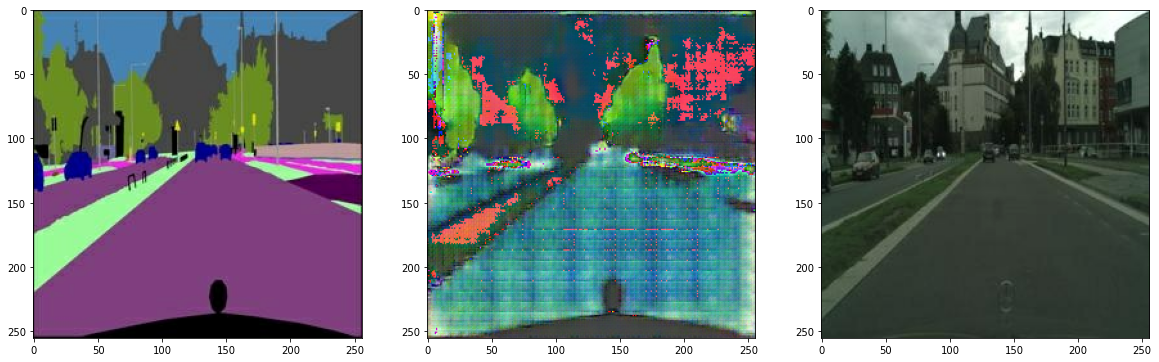

In [34]:
test_ind = 4
val_path = os.getenv('HOME')+'/AIFFEL/Exploration/E20_Pix2Pix/data/cityscapes/val'

f = data_path + os.listdir(val_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

### 루브릭
---
* pix2pix 모델 학습을 위해 필요한 데이터셋을 적절히 구축하였다.<br>
(_데이터 분석 과정 및 한 가지 이상의 augmentation을 포함한 데이터셋 구축 과정이 체계적으로 제시되었다._)
    * __다양한 augmentation을 했다.__

* pix2pix 모델을 구현하여 성공적으로 학습 과정을 진행하였다.<br>
(_U-Net generator, discriminator 모델 구현이 완료되어 train_step이 안정적으로 진행됨을 확인하였다._)
    * __모델을 성공적으로 구현하고 진행됨을 확인했다.__

* 학습 과정 및 테스트에 대한 시각화 결과를 제출하였다.<br>
(_10 epoch 이상의 학습을 진행한 후 최종 테스트 결과에서 진행한 epoch 수에 걸맞은 정도의 품질을 확인하였다._)
    * __300에폭 해봤는데 어느정도 나온 모습이다.__